In [1]:
#!pip install theano
#!pip install keras
#!pip install tensorflow

In [2]:
import os, sys
import pickle
currentdir = os.path.dirname(os.path.realpath(os.path.abspath("")))
scriptsdir = os.path.dirname(currentdir)
if scriptsdir not in sys.path:
    sys.path.append(scriptsdir)

from customscripts import configuration
from customscripts import utils
from week6.abi.solution_scripts import data_wrangling
from week6.abi.solution_scripts.Networks import (LSTM, Facebook, ANN, VAR)
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import LabelEncoder



In [3]:

#%matplotlib inline
register_matplotlib_converters()
%load_ext autoreload
%autoreload 2

In [4]:
main_data = pd.read_csv('clean_data.csv',index_col='Time')

In [5]:
main_data = main_data.replace([np.inf, -np.inf], np.nan)
main_data[main_data.isna().any(axis=1)]

,Reporter,Commodity Code,Trade Value (US$),Category Code,Gdp_per_capita,Population
Time,,,,,,


In [6]:
main_data.index = pd.to_datetime(main_data.index, format="%Y-%m-%d").to_period('M')

In [7]:
output_column = 'Trade Value (US$)'

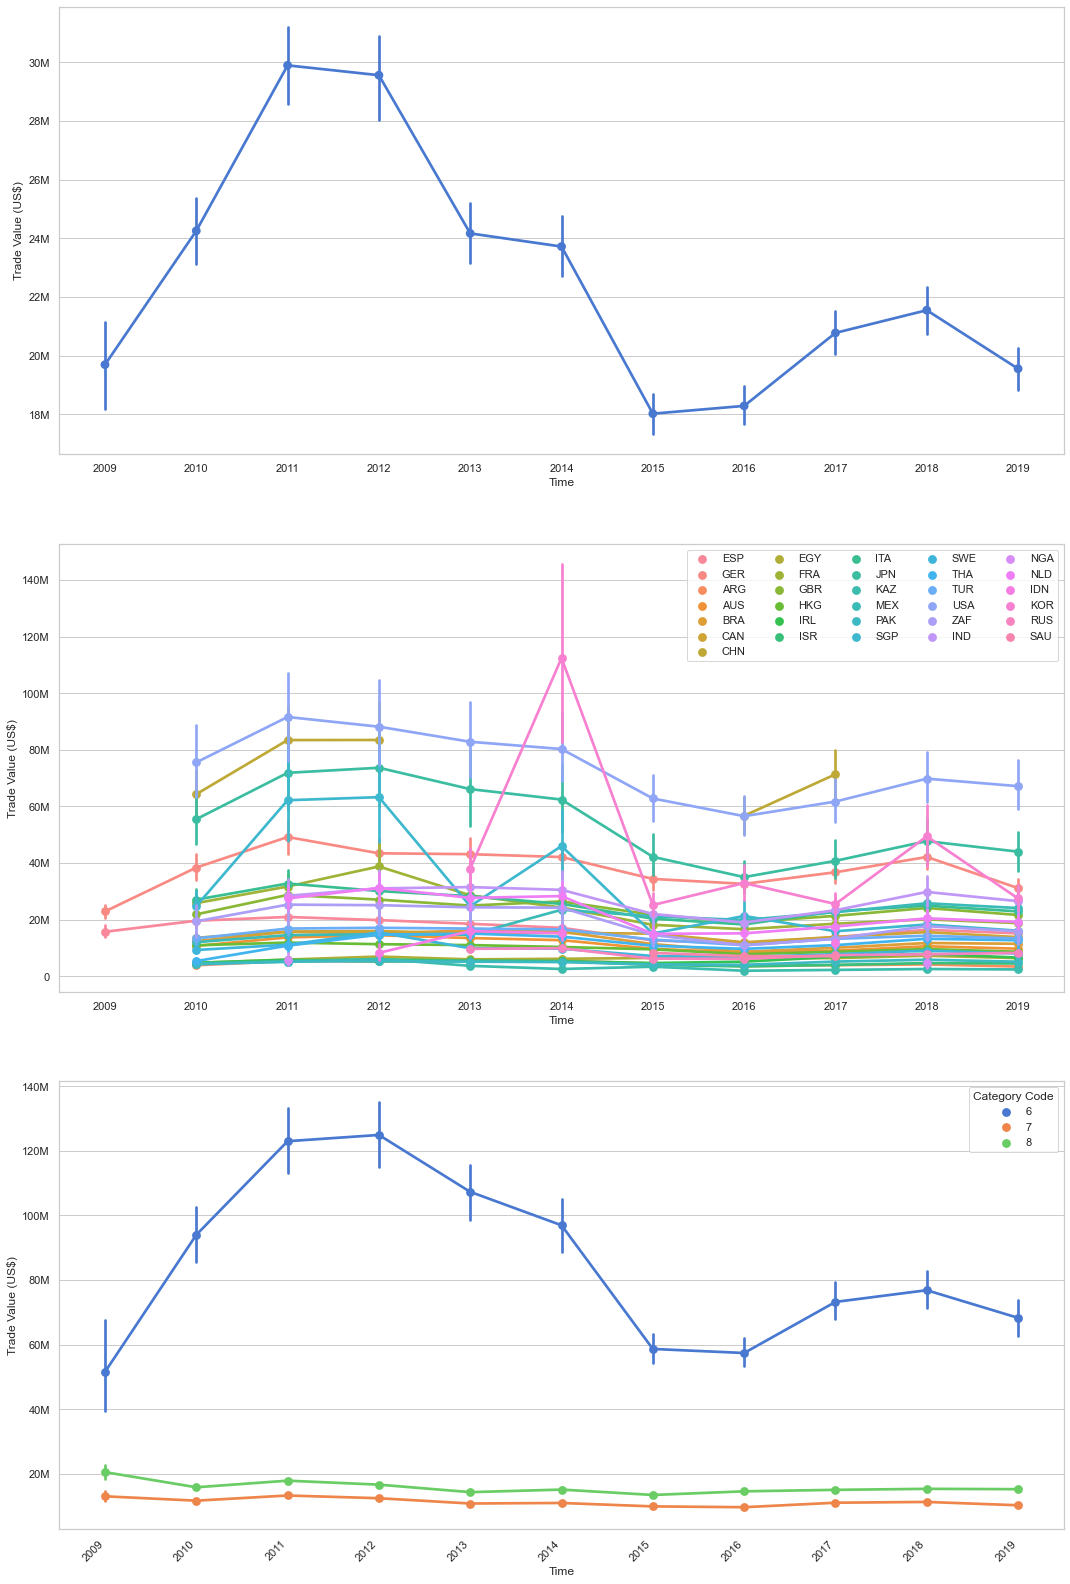

In [8]:

sns.set(style='whitegrid', palette='muted')
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18, 28)
plt.xticks(rotation=45, horizontalalignment='right')
data = main_data.copy()
#data.index = pd.DatetimeIndex(data.index).year
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g = sns.pointplot(x=data.index.year, y=output_column, data=data, ax=ax1);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));

g = sns.pointplot(x=data.index.year, y=output_column, data=data, hue="Reporter", ax=ax2);
handles = g.legend_.legendHandles
labels = g.legend_.get_label()
g.legend(handles=handles, labels=labels, loc='upper right', ncol=5)
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g = sns.pointplot(x=data.index.year, y=output_column, data=data, hue="Category Code", ax=ax3);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));





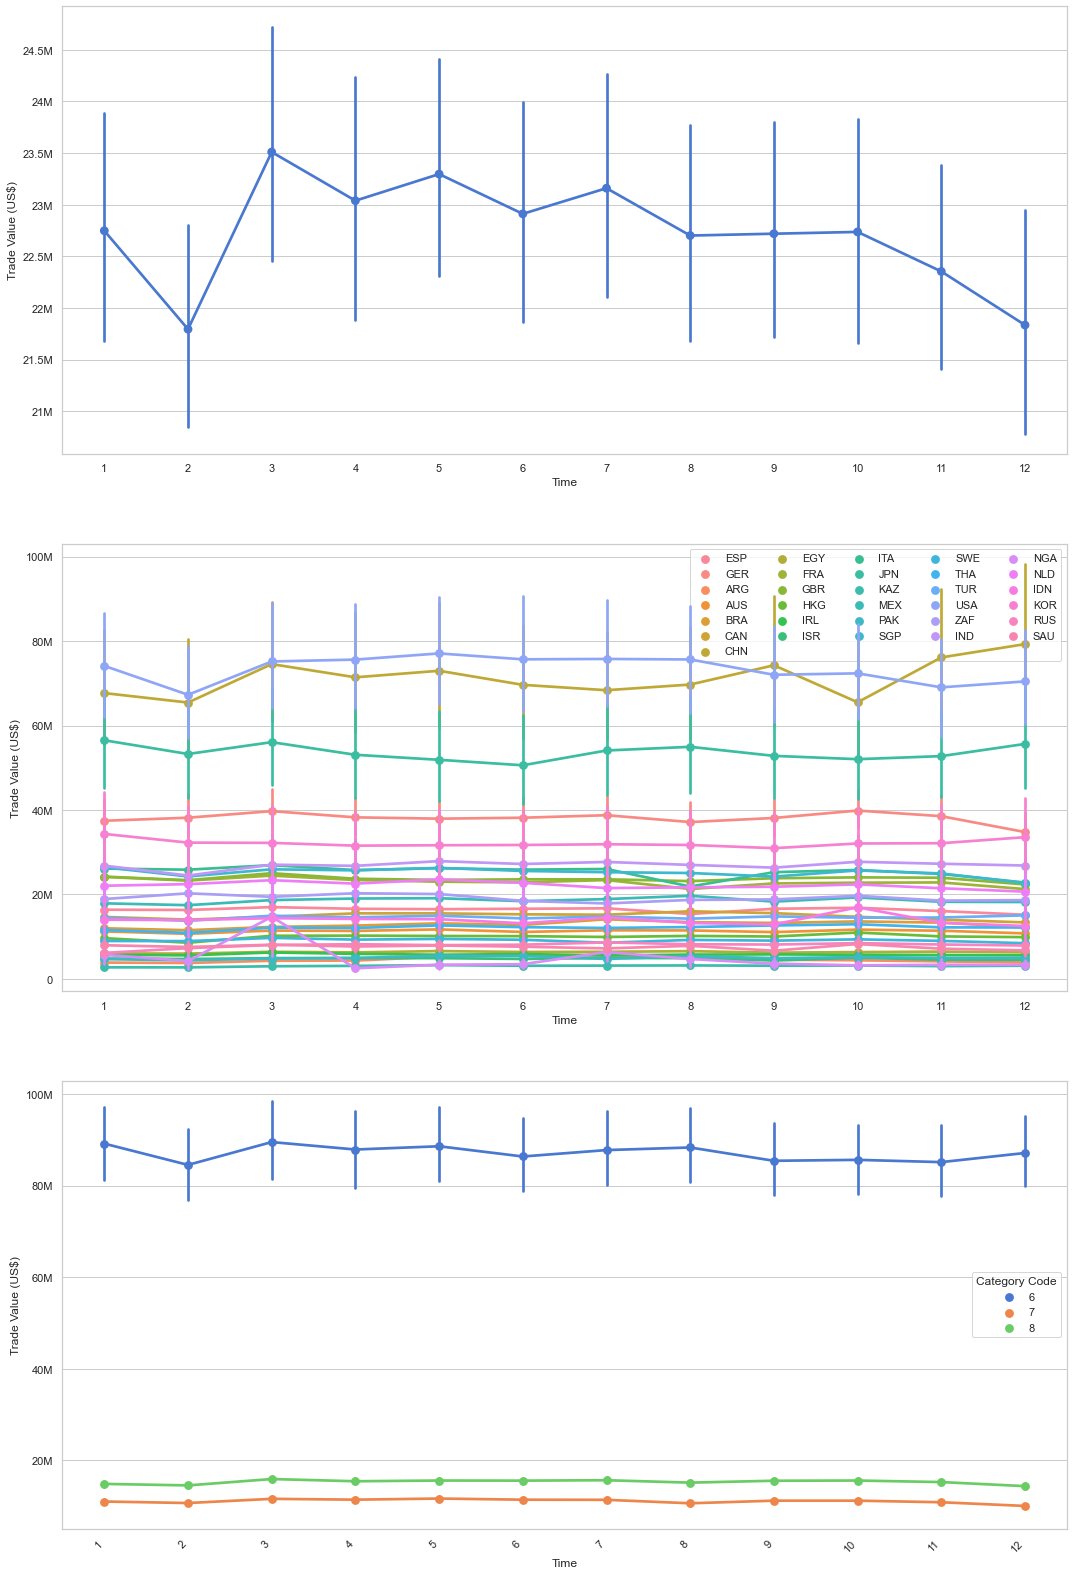

In [9]:
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(18, 28)
plt.xticks(rotation=45, horizontalalignment='right')
data = main_data.copy()
#data.index = pd.DatetimeIndex(data.index).year
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g = sns.pointplot(x=data.index.month, y=output_column, data=data, ax=ax1);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));

g = sns.pointplot(x=data.index.month, y=output_column, data=data, hue="Reporter", ax=ax2);
handles = g.legend_.legendHandles
labels = g.legend_.get_label()
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g.legend(handles=handles, labels=labels, loc='upper right', ncol=5)

g=sns.pointplot(x=data.index.month, y=output_column, data=data, hue="Category Code", ax=ax3);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));

In [3]:
sns.set_theme()

# Summary of models
## FB Prophet
* FB Prophet gives the best accuracy from the models tested so far
* This model is typically used for univariant time series data
* We removed columns all categorical values (Commodity, Reporter). The train dataset is monthly average trade value for each product category till 2018. The test dataset is the monthly average trade value for each category in the year 2019
* FB prophet performs quite well and is also able to predict the trends. The average loss is 1509.086318
## VAR
* Vector Auto regression (VAR) is a statistical auto regression model that is typically used for multi-variant time series data
* To prepare the data, we removed the Commodity column. We then averaged the trade value of each product categoryper Reporter and their population data. 
* The train data set is the per reporter monthly average trade value for each product category and the population data till 2018. The test dataset is the per reporter monthly average trade value for each category in the year 2019 and population.
* We then group the train data into commodity categories, drop the reporter column, because VAR doesn't accept categorical data. The model is trained for each product category
* Compared to the FB prophet, VAR doesn't perform as good. It is unable to seemingly detect trends and monthly spikes in the data for each product category. It average loss is 30775720 which is higher than that of fb phrophet
## ANN
* Our artificial nneural network is a multilayer perceptron
* Due to the mixed nature of our data set (numerical and categorical), we need a model that performs both classification and regression. To achieve this, hidden layers are used for classification, then the final layer is the regression layer (linear). ReLu activation is used between layers
* Preprocessing: A Robust scaler is used to scale the numerical input features (Trade Value, GDP per capita, Population) and, while the categorical columns (Reporter, Product Category) are one-hot encoded as binary value of each label. Addtionally, the monthly trade value for each reporter per commodity is also averaged
* Robust Scaler is used to scale features using statistics that are robust to outliers. It removes the median and scales the data according to IQR (IQR: Interquartile Range). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Median and interquartile range are then stored to be used on later data using the transform method
* Architecture: After rigorous training and tests using different models, a Multilayer perceptron with three hidden layers was selected. The first layer (input layer), has 512 neurons, second layer, 256, third layer 128, fourth layer 64, and finally a linear output layer. Relu gave the best result and was selected as the optimal activation function for our model. A drop out layer and batch normalization were also added in between the layers, for regularization. He Initialization was used for initializing the weights of each layer

* Training: 25% of the train data is used for validation. Our model is initialized with the Adam optimizer. We’re using mean absolute error as our loss function, indicating that we seek to minimize the mean difference between the predicted trade value and the actual trade value. 

* Overall the best mean absolute percentage that we were able to obtain with our neural network, after rigorous training and hyper paramter tuning was a mean absolute error of 638.05%, implying that, on average, our trade value predictions will be off by 638.05%, with a standard deviation of 9077.56%. This is a very bad result, and on a average, it shows that a simple ANN is simply not able to determine the trends in our dataset. 


## Train with ANN

In regression model, the most commonly known evaluation metrics include:

R-squared (R2), which is the proportion of variation in the outcome that is explained by the predictor variables. In multiple regression models, R2 corresponds to the squared correlation between the observed outcome values and the predicted values by the model. The Higher the R-squared, the better the model.

Root Mean Squared Error (RMSE), which measures the average error performed by the model in predicting the outcome for an observation. Mathematically, the RMSE is the square root of the mean squared error (MSE), which is the average squared difference between the observed actual outome values and the values predicted by the model. So, MSE = mean((observeds - predicteds)^2) and RMSE = sqrt(MSE). The lower the RMSE, the better the model.

Residual Standard Error (RSE), also known as the model sigma, is a variant of the RMSE adjusted for the number of predictors in the model. The lower the RSE, the better the model. In practice, the difference between RMSE and RSE is very small, particularly for large multivariate data.

Mean Absolute Error (MAE), like the RMSE, the MAE measures the prediction error. Mathematically, it is the average absolute difference between observed and predicted outcomes, MAE = mean(abs(observeds - predicteds)). MAE is less sensitive to outliers compared to RMSE.


In [50]:
from sklearn.model_selection import train_test_split
data = main_data.groupby(['Time','Reporter', 'Category Code']).agg({output_column:'mean', 'Population':'last', 'Gdp_per_capita':'last'}).reset_index().set_index('Time')
data = pd.get_dummies(data, columns=['Reporter', 'Category Code'])
train_raw = data[data.index<"2019"]
test_raw = data[data.index>="2019"]
train_raw, val_raw = train_test_split(train_raw, test_size=0.2, random_state=42)

In [51]:
ann = ANN(df=data.copy(), output_column=output_column, continuous_cols=['Gdp_per_capita', 'Population'], train_raw=train_raw, val_raw = val_raw, test_raw=test_raw)
trainx, trainY,  valx, valY= ann.prepare()
ann.create_model(512)

In [20]:
size_histories = {}

In [52]:
def train(ann, size_histories, hparams, model_name, csv_filename, recreate_model=False, neurons=256):
  if recreate_model:
    ann.create_model(neurons)
  hist, model = ann.train_model(hparams, model_name, csv_filename)
  size_histories[model_name] = hist
  return model, size_histories


In [45]:
def plot_loss_acc(result, title1, title2, loss_pic_title, with_log):
    plt.plot(result['loss'])
    plt.plot(result['val_loss'])
    plt.title(title1)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    if with_log:
        plt.yscale('log')
    plt.savefig(loss_pic_title);
    plt.show();
    

In [42]:
ann.train_trials(50)
#{'dropout_1': 0.26,
# 'dropout_2': 0.31000000000000005,
# 'dropout_3': 0.36000000000000004,
# 'lr': 0.0003309373119942461,
# 'decay': 0.0002653252665537072,
# 'batchsize': 108}

Epoch 1/15
5/5 - 1s - loss: 1.3224 - val_loss: 0.2815
Epoch 2/15
5/5 - 0s - loss: 1.1700 - val_loss: 0.2744
Epoch 3/15
5/5 - 0s - loss: 1.1808 - val_loss: 0.2737
Epoch 4/15
5/5 - 0s - loss: 1.2371 - val_loss: 0.2697
Epoch 5/15
5/5 - 0s - loss: 1.1645 - val_loss: 0.2677
Epoch 6/15
5/5 - 0s - loss: 1.2100 - val_loss: 0.2633
Epoch 7/15
5/5 - 0s - loss: 1.1663 - val_loss: 0.2503
Epoch 8/15
5/5 - 0s - loss: 1.1209 - val_loss: 0.2408
Epoch 9/15
5/5 - 0s - loss: 1.1590 - val_loss: 0.2327
Epoch 10/15
5/5 - 0s - loss: 1.0891 - val_loss: 0.2264
Epoch 11/15
5/5 - 0s - loss: 1.0825 - val_loss: 0.2236
Epoch 12/15
5/5 - 0s - loss: 1.0829 - val_loss: 0.2236
Epoch 13/15
5/5 - 0s - loss: 1.1554 - val_loss: 0.2256
Epoch 14/15
5/5 - 0s - loss: 1.1013 - val_loss: 0.2306
Epoch 15/15
5/5 - 0s - loss: 1.0269 - val_loss: 0.2437


[I 2021-01-26 22:17:41,653] Finished trial#0 with value: 0.24369846284389496 with parameters: {'lr': 4.938253537141298e-05, 'decay': 3.322620544044297e-05, 'batchsize': 68}. Best is trial#0 with value: 0.24369846284389496.


Epoch 1/15
2/2 - 1s - loss: 1.1722 - val_loss: 0.2545
Epoch 2/15
2/2 - 0s - loss: 1.0952 - val_loss: 0.2365
Epoch 3/15
2/2 - 0s - loss: 1.1084 - val_loss: 0.2369
Epoch 4/15
2/2 - 0s - loss: 1.1329 - val_loss: 0.2805
Epoch 5/15
2/2 - 0s - loss: 1.0368 - val_loss: 0.3152
Epoch 6/15
2/2 - 0s - loss: 1.0624 - val_loss: 0.3266
Epoch 7/15
2/2 - 0s - loss: 1.0164 - val_loss: 0.3316
Epoch 8/15
2/2 - 0s - loss: 1.0368 - val_loss: 0.3198
Epoch 9/15
2/2 - 0s - loss: 1.0181 - val_loss: 0.3060
Epoch 10/15
2/2 - 0s - loss: 1.0072 - val_loss: 0.2871
Epoch 11/15
2/2 - 0s - loss: 0.9200 - val_loss: 0.2607
Epoch 12/15
2/2 - 0s - loss: 0.9639 - val_loss: 0.2476
Epoch 13/15
2/2 - 0s - loss: 0.9469 - val_loss: 0.2420
Epoch 14/15
2/2 - 0s - loss: 0.9566 - val_loss: 0.2360
Epoch 15/15
2/2 - 0s - loss: 0.9970 - val_loss: 0.2282


[I 2021-01-26 22:17:43,632] Finished trial#1 with value: 0.22816967964172363 with parameters: {'lr': 0.00040917530458336, 'decay': 1.7962382922537688e-05, 'batchsize': 308}. Best is trial#1 with value: 0.22816967964172363.


Epoch 1/15
1/1 - 1s - loss: 0.9834 - val_loss: 0.2321
Epoch 2/15
1/1 - 0s - loss: 0.8421 - val_loss: 0.2407
Epoch 3/15
1/1 - 0s - loss: 0.8512 - val_loss: 0.2358
Epoch 4/15
1/1 - 0s - loss: 0.8996 - val_loss: 0.2230
Epoch 5/15
1/1 - 0s - loss: 0.9156 - val_loss: 0.2100
Epoch 6/15
1/1 - 0s - loss: 0.9032 - val_loss: 0.2064
Epoch 7/15
1/1 - 0s - loss: 0.8859 - val_loss: 0.2076
Epoch 8/15
1/1 - 0s - loss: 0.8703 - val_loss: 0.2026
Epoch 9/15
1/1 - 0s - loss: 0.8536 - val_loss: 0.1943
Epoch 10/15
1/1 - 0s - loss: 0.8906 - val_loss: 0.1940
Epoch 11/15
1/1 - 0s - loss: 0.9258 - val_loss: 0.1973
Epoch 12/15
1/1 - 0s - loss: 0.8157 - val_loss: 0.2033
Epoch 13/15
1/1 - 0s - loss: 0.8604 - val_loss: 0.2177
Epoch 14/15
1/1 - 0s - loss: 0.7998 - val_loss: 0.2261
Epoch 15/15
1/1 - 0s - loss: 0.8733 - val_loss: 0.2336


[I 2021-01-26 22:17:45,586] Finished trial#2 with value: 0.23361200094223022 with parameters: {'lr': 0.0002224093594301718, 'decay': 0.0037282178954674643, 'batchsize': 428}. Best is trial#1 with value: 0.22816967964172363.


Epoch 1/15
1/1 - 1s - loss: 0.8676 - val_loss: 0.2310
Epoch 2/15
1/1 - 0s - loss: 0.8202 - val_loss: 0.2286
Epoch 3/15
1/1 - 0s - loss: 0.8418 - val_loss: 0.2275
Epoch 4/15
1/1 - 0s - loss: 0.8772 - val_loss: 0.2260
Epoch 5/15
1/1 - 0s - loss: 0.8271 - val_loss: 0.2248
Epoch 6/15
1/1 - 0s - loss: 0.8577 - val_loss: 0.2232
Epoch 7/15
1/1 - 0s - loss: 0.8219 - val_loss: 0.2219
Epoch 8/15
1/1 - 0s - loss: 0.8569 - val_loss: 0.2212
Epoch 9/15
1/1 - 0s - loss: 0.8282 - val_loss: 0.2204
Epoch 10/15
1/1 - 0s - loss: 0.8545 - val_loss: 0.2202
Epoch 11/15
1/1 - 0s - loss: 0.7909 - val_loss: 0.2200
Epoch 12/15
1/1 - 0s - loss: 0.8010 - val_loss: 0.2194
Epoch 13/15
1/1 - 0s - loss: 0.8662 - val_loss: 0.2193
Epoch 14/15
1/1 - 0s - loss: 0.9012 - val_loss: 0.2196
Epoch 15/15
1/1 - 0s - loss: 0.8249 - val_loss: 0.2194


[I 2021-01-26 22:17:47,529] Finished trial#3 with value: 0.21943210065364838 with parameters: {'lr': 1.1269703632097898e-05, 'decay': 0.0727649808357037, 'batchsize': 512}. Best is trial#3 with value: 0.21943210065364838.


Epoch 1/15
2/2 - 1s - loss: 0.8313 - val_loss: 0.2210
Epoch 2/15
2/2 - 0s - loss: 0.8989 - val_loss: 0.2178
Epoch 3/15
2/2 - 0s - loss: 0.8058 - val_loss: 0.2143
Epoch 4/15
2/2 - 0s - loss: 0.8815 - val_loss: 0.2109
Epoch 5/15
2/2 - 0s - loss: 0.8853 - val_loss: 0.2087
Epoch 6/15
2/2 - 0s - loss: 0.7923 - val_loss: 0.2060
Epoch 7/15
2/2 - 0s - loss: 0.8496 - val_loss: 0.2036
Epoch 8/15
2/2 - 0s - loss: 0.8025 - val_loss: 0.2017
Epoch 9/15
2/2 - 0s - loss: 0.7849 - val_loss: 0.2001
Epoch 10/15
2/2 - 0s - loss: 0.8510 - val_loss: 0.2015
Epoch 11/15
2/2 - 0s - loss: 0.8286 - val_loss: 0.2046
Epoch 12/15
2/2 - 0s - loss: 0.7901 - val_loss: 0.2076
Epoch 13/15
2/2 - 0s - loss: 0.8491 - val_loss: 0.2107
Epoch 14/15
2/2 - 0s - loss: 0.8143 - val_loss: 0.2155
Epoch 15/15
2/2 - 0s - loss: 0.8437 - val_loss: 0.2198


[I 2021-01-26 22:17:49,486] Finished trial#4 with value: 0.21976986527442932 with parameters: {'lr': 2.6525342631279764e-05, 'decay': 0.0003977608074198133, 'batchsize': 164}. Best is trial#3 with value: 0.21943210065364838.


Epoch 1/15
5/5 - 1s - loss: 0.8070 - val_loss: 0.2003
Epoch 2/15
5/5 - 0s - loss: 0.8641 - val_loss: 0.1927
Epoch 3/15
5/5 - 0s - loss: 0.8247 - val_loss: 0.1884
Epoch 4/15
5/5 - 0s - loss: 0.8400 - val_loss: 0.1859
Epoch 5/15
5/5 - 0s - loss: 0.7430 - val_loss: 0.1835
Epoch 6/15
5/5 - 0s - loss: 0.8129 - val_loss: 0.1829
Epoch 7/15
5/5 - 0s - loss: 0.7786 - val_loss: 0.1821
Epoch 8/15
5/5 - 0s - loss: 0.8500 - val_loss: 0.1868
Epoch 9/15
5/5 - 0s - loss: 0.8862 - val_loss: 0.1834
Epoch 10/15
5/5 - 0s - loss: 0.8547 - val_loss: 0.1909
Epoch 11/15
5/5 - 0s - loss: 0.7846 - val_loss: 0.1893
Epoch 12/15
5/5 - 0s - loss: 0.8012 - val_loss: 0.1897
Epoch 13/15
5/5 - 0s - loss: 0.8142 - val_loss: 0.1902
Epoch 14/15
5/5 - 0s - loss: 0.8674 - val_loss: 0.1906
Epoch 15/15
5/5 - 0s - loss: 0.8038 - val_loss: 0.1893


[I 2021-01-26 22:17:51,490] Finished trial#5 with value: 0.18932773172855377 with parameters: {'lr': 1.9181289693935698e-05, 'decay': 0.0007634483438864456, 'batchsize': 80}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
2/2 - 1s - loss: 0.8697 - val_loss: 0.2529
Epoch 2/15
2/2 - 0s - loss: 0.8187 - val_loss: 0.2401
Epoch 3/15
2/2 - 0s - loss: 0.8493 - val_loss: 0.2310
Epoch 4/15
2/2 - 0s - loss: 0.7843 - val_loss: 0.2364
Epoch 5/15
2/2 - 0s - loss: 0.7763 - val_loss: 0.2466
Epoch 6/15
2/2 - 0s - loss: 0.7662 - val_loss: 0.2518
Epoch 7/15
2/2 - 0s - loss: 0.7976 - val_loss: 0.2510
Epoch 8/15
2/2 - 0s - loss: 0.8039 - val_loss: 0.2473
Epoch 9/15
2/2 - 0s - loss: 0.7137 - val_loss: 0.2390
Epoch 10/15
2/2 - 0s - loss: 0.7763 - val_loss: 0.2301
Epoch 11/15
2/2 - 0s - loss: 0.7176 - val_loss: 0.2158
Epoch 12/15
2/2 - 0s - loss: 0.7878 - val_loss: 0.2062
Epoch 13/15
2/2 - 0s - loss: 0.7561 - val_loss: 0.2079
Epoch 14/15
2/2 - 0s - loss: 0.7154 - val_loss: 0.2342
Epoch 15/15
2/2 - 0s - loss: 0.7401 - val_loss: 0.2586


[I 2021-01-26 22:17:53,470] Finished trial#6 with value: 0.25861856341362 with parameters: {'lr': 0.00023715418983406204, 'decay': 0.0005931311791068324, 'batchsize': 296}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
2/2 - 1s - loss: 0.7258 - val_loss: 0.2588
Epoch 2/15
2/2 - 0s - loss: 0.6879 - val_loss: 0.2206
Epoch 3/15
2/2 - 0s - loss: 0.7374 - val_loss: 0.2078
Epoch 4/15
2/2 - 0s - loss: 0.7065 - val_loss: 0.2090
Epoch 5/15
2/2 - 0s - loss: 0.7235 - val_loss: 0.2126
Epoch 6/15
2/2 - 0s - loss: 0.6884 - val_loss: 0.2228
Epoch 7/15
2/2 - 0s - loss: 0.7052 - val_loss: 0.2200
Epoch 8/15
2/2 - 0s - loss: 0.6954 - val_loss: 0.2168
Epoch 9/15
2/2 - 0s - loss: 0.7190 - val_loss: 0.2210
Epoch 10/15
2/2 - 0s - loss: 0.6936 - val_loss: 0.2352
Epoch 11/15
2/2 - 0s - loss: 0.6576 - val_loss: 0.2555
Epoch 12/15
2/2 - 0s - loss: 0.7046 - val_loss: 0.2713
Epoch 13/15
2/2 - 0s - loss: 0.6351 - val_loss: 0.2917
Epoch 14/15
2/2 - 0s - loss: 0.6934 - val_loss: 0.3078
Epoch 15/15
2/2 - 0s - loss: 0.6286 - val_loss: 0.3368


[I 2021-01-26 22:17:55,423] Finished trial#7 with value: 0.33679988980293274 with parameters: {'lr': 0.00020463741817106144, 'decay': 2.3581856228593947e-05, 'batchsize': 164}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
3/3 - 1s - loss: 0.7204 - val_loss: 0.3199
Epoch 2/15
3/3 - 0s - loss: 0.6625 - val_loss: 0.3233
Epoch 3/15
3/3 - 0s - loss: 0.6672 - val_loss: 0.3149
Epoch 4/15
3/3 - 0s - loss: 0.6819 - val_loss: 0.2902
Epoch 5/15
3/3 - 0s - loss: 0.6379 - val_loss: 0.2896
Epoch 6/15
3/3 - 0s - loss: 0.6614 - val_loss: 0.2792
Epoch 7/15
3/3 - 0s - loss: 0.6288 - val_loss: 0.2599
Epoch 8/15
3/3 - 0s - loss: 0.6348 - val_loss: 0.2596
Epoch 9/15
3/3 - 0s - loss: 0.5897 - val_loss: 0.2571
Epoch 10/15
3/3 - 0s - loss: 0.6444 - val_loss: 0.2522
Epoch 11/15
3/3 - 0s - loss: 0.6060 - val_loss: 0.2389
Epoch 12/15
3/3 - 0s - loss: 0.6492 - val_loss: 0.2312
Epoch 13/15
3/3 - 0s - loss: 0.6576 - val_loss: 0.2438
Epoch 14/15
3/3 - 0s - loss: 0.6335 - val_loss: 0.2635
Epoch 15/15
3/3 - 0s - loss: 0.6652 - val_loss: 0.2711


[I 2021-01-26 22:17:57,428] Finished trial#8 with value: 0.27114778757095337 with parameters: {'lr': 0.0001407488869406037, 'decay': 0.005848348449605921, 'batchsize': 140}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
1/1 - 1s - loss: 0.5816 - val_loss: 0.2003
Epoch 2/15
1/1 - 0s - loss: 0.6287 - val_loss: 0.2436
Epoch 3/15
1/1 - 0s - loss: 0.6399 - val_loss: 0.3187
Epoch 4/15
1/1 - 0s - loss: 0.6121 - val_loss: 0.4120
Epoch 5/15
1/1 - 0s - loss: 0.6277 - val_loss: 0.4322
Epoch 6/15
1/1 - 0s - loss: 0.6258 - val_loss: 0.4041
Epoch 7/15
1/1 - 0s - loss: 0.5877 - val_loss: 0.3519
Epoch 8/15
1/1 - 0s - loss: 0.6277 - val_loss: 0.3420
Epoch 9/15
1/1 - 0s - loss: 0.6007 - val_loss: 0.3563
Epoch 10/15
1/1 - 0s - loss: 0.5742 - val_loss: 0.3743
Epoch 11/15
1/1 - 0s - loss: 0.5553 - val_loss: 0.3833
Epoch 12/15
1/1 - 0s - loss: 0.5834 - val_loss: 0.4018
Epoch 13/15
1/1 - 0s - loss: 0.5964 - val_loss: 0.3990
Epoch 14/15
1/1 - 0s - loss: 0.5378 - val_loss: 0.4146
Epoch 15/15
1/1 - 0s - loss: 0.5683 - val_loss: 0.3963


[I 2021-01-26 22:17:59,325] Finished trial#9 with value: 0.3963273763656616 with parameters: {'lr': 0.0005611220657709995, 'decay': 3.372562547290467e-05, 'batchsize': 464}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
4/4 - 1s - loss: 0.6198 - val_loss: 0.3816
Epoch 2/15
4/4 - 0s - loss: 0.5445 - val_loss: 0.3703
Epoch 3/15
4/4 - 0s - loss: 0.6252 - val_loss: 0.3530
Epoch 4/15
4/4 - 0s - loss: 0.5223 - val_loss: 0.3451
Epoch 5/15
4/4 - 0s - loss: 0.5667 - val_loss: 0.3386
Epoch 6/15
4/4 - 0s - loss: 0.5489 - val_loss: 0.3306
Epoch 7/15
4/4 - 0s - loss: 0.5608 - val_loss: 0.3223
Epoch 8/15
4/4 - 0s - loss: 0.5676 - val_loss: 0.3166
Epoch 9/15
4/4 - 0s - loss: 0.5708 - val_loss: 0.3128
Epoch 10/15
4/4 - 0s - loss: 0.5557 - val_loss: 0.3095
Epoch 11/15
4/4 - 0s - loss: 0.5727 - val_loss: 0.3087
Epoch 12/15
4/4 - 0s - loss: 0.5714 - val_loss: 0.3048
Epoch 13/15
4/4 - 0s - loss: 0.5993 - val_loss: 0.3021
Epoch 14/15
4/4 - 0s - loss: 0.5590 - val_loss: 0.2976
Epoch 15/15
4/4 - 0s - loss: 0.5911 - val_loss: 0.2991


[I 2021-01-26 22:18:01,341] Finished trial#10 with value: 0.29905620217323303 with parameters: {'lr': 1.2334055672902351e-05, 'decay': 0.09556373788064987, 'batchsize': 104}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
1/1 - 1s - loss: 0.5504 - val_loss: 0.2991
Epoch 2/15
1/1 - 0s - loss: 0.5715 - val_loss: 0.2982
Epoch 3/15
1/1 - 0s - loss: 0.5485 - val_loss: 0.2963
Epoch 4/15
1/1 - 0s - loss: 0.6058 - val_loss: 0.2946
Epoch 5/15
1/1 - 0s - loss: 0.5568 - val_loss: 0.2935
Epoch 6/15
1/1 - 0s - loss: 0.6050 - val_loss: 0.2924
Epoch 7/15
1/1 - 0s - loss: 0.5673 - val_loss: 0.2910
Epoch 8/15
1/1 - 0s - loss: 0.5191 - val_loss: 0.2893
Epoch 9/15
1/1 - 0s - loss: 0.5779 - val_loss: 0.2880
Epoch 10/15
1/1 - 0s - loss: 0.5252 - val_loss: 0.2872
Epoch 11/15
1/1 - 0s - loss: 0.5179 - val_loss: 0.2862
Epoch 12/15
1/1 - 0s - loss: 0.5800 - val_loss: 0.2853
Epoch 13/15
1/1 - 0s - loss: 0.5743 - val_loss: 0.2844
Epoch 14/15
1/1 - 0s - loss: 0.5345 - val_loss: 0.2840
Epoch 15/15
1/1 - 0s - loss: 0.5434 - val_loss: 0.2834


[I 2021-01-26 22:18:03,386] Finished trial#11 with value: 0.28338465094566345 with parameters: {'lr': 1.0408786368721104e-05, 'decay': 0.07189945203982874, 'batchsize': 380}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
2/2 - 1s - loss: 0.5892 - val_loss: 0.2861
Epoch 2/15
2/2 - 0s - loss: 0.5818 - val_loss: 0.2868
Epoch 3/15
2/2 - 0s - loss: 0.5631 - val_loss: 0.2874
Epoch 4/15
2/2 - 0s - loss: 0.5390 - val_loss: 0.2867
Epoch 5/15
2/2 - 0s - loss: 0.5570 - val_loss: 0.2855
Epoch 6/15
2/2 - 0s - loss: 0.5161 - val_loss: 0.2842
Epoch 7/15
2/2 - 0s - loss: 0.5785 - val_loss: 0.2839
Epoch 8/15
2/2 - 0s - loss: 0.5600 - val_loss: 0.2831
Epoch 9/15
2/2 - 0s - loss: 0.5442 - val_loss: 0.2825
Epoch 10/15
2/2 - 0s - loss: 0.5521 - val_loss: 0.2831
Epoch 11/15
2/2 - 0s - loss: 0.6017 - val_loss: 0.2826
Epoch 12/15
2/2 - 0s - loss: 0.5559 - val_loss: 0.2810
Epoch 13/15
2/2 - 0s - loss: 0.5586 - val_loss: 0.2797
Epoch 14/15
2/2 - 0s - loss: 0.5334 - val_loss: 0.2790
Epoch 15/15
2/2 - 0s - loss: 0.5499 - val_loss: 0.2773


[I 2021-01-26 22:18:05,301] Finished trial#12 with value: 0.27734076976776123 with parameters: {'lr': 2.3946317361853093e-05, 'decay': 0.01324862359224038, 'batchsize': 224}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
1/1 - 1s - loss: 0.5246 - val_loss: 0.2766
Epoch 2/15
1/1 - 0s - loss: 0.5372 - val_loss: 0.2828
Epoch 3/15
1/1 - 0s - loss: 0.6108 - val_loss: 0.2884
Epoch 4/15
1/1 - 0s - loss: 0.5681 - val_loss: 0.2910
Epoch 5/15
1/1 - 0s - loss: 0.5619 - val_loss: 0.2908
Epoch 6/15
1/1 - 0s - loss: 0.5411 - val_loss: 0.2904
Epoch 7/15
1/1 - 0s - loss: 0.5560 - val_loss: 0.2878
Epoch 8/15
1/1 - 0s - loss: 0.5559 - val_loss: 0.2846
Epoch 9/15
1/1 - 0s - loss: 0.5348 - val_loss: 0.2829
Epoch 10/15
1/1 - 0s - loss: 0.5463 - val_loss: 0.2804
Epoch 11/15
1/1 - 0s - loss: 0.5492 - val_loss: 0.2778
Epoch 12/15
1/1 - 0s - loss: 0.5589 - val_loss: 0.2738
Epoch 13/15
1/1 - 0s - loss: 0.5619 - val_loss: 0.2701
Epoch 14/15
1/1 - 0s - loss: 0.5226 - val_loss: 0.2668
Epoch 15/15
1/1 - 0s - loss: 0.5422 - val_loss: 0.2631


[I 2021-01-26 22:18:07,425] Finished trial#13 with value: 0.2631385028362274 with parameters: {'lr': 5.4808515331303707e-05, 'decay': 0.00019131842730003916, 'batchsize': 512}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
2/2 - 1s - loss: 0.5815 - val_loss: 0.2612
Epoch 2/15
2/2 - 0s - loss: 0.5617 - val_loss: 0.2601
Epoch 3/15
2/2 - 0s - loss: 0.5402 - val_loss: 0.2560
Epoch 4/15
2/2 - 0s - loss: 0.5343 - val_loss: 0.2518
Epoch 5/15
2/2 - 0s - loss: 0.5596 - val_loss: 0.2492
Epoch 6/15
2/2 - 0s - loss: 0.5294 - val_loss: 0.2470
Epoch 7/15
2/2 - 0s - loss: 0.5363 - val_loss: 0.2437
Epoch 8/15
2/2 - 0s - loss: 0.5834 - val_loss: 0.2420
Epoch 9/15
2/2 - 0s - loss: 0.5299 - val_loss: 0.2400
Epoch 10/15
2/2 - 0s - loss: 0.5227 - val_loss: 0.2367
Epoch 11/15
2/2 - 0s - loss: 0.5423 - val_loss: 0.2338
Epoch 12/15
2/2 - 0s - loss: 0.5895 - val_loss: 0.2310
Epoch 13/15
2/2 - 0s - loss: 0.5713 - val_loss: 0.2286
Epoch 14/15
2/2 - 0s - loss: 0.5242 - val_loss: 0.2284
Epoch 15/15
2/2 - 0s - loss: 0.5747 - val_loss: 0.2287


[I 2021-01-26 22:18:09,451] Finished trial#14 with value: 0.22869791090488434 with parameters: {'lr': 1.7899006093241037e-05, 'decay': 0.0018996260940746718, 'batchsize': 236}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
1/1 - 1s - loss: 0.5667 - val_loss: 0.2301
Epoch 2/15
1/1 - 0s - loss: 0.5679 - val_loss: 0.2318
Epoch 3/15
1/1 - 0s - loss: 0.5943 - val_loss: 0.2359
Epoch 4/15
1/1 - 0s - loss: 0.5351 - val_loss: 0.2391
Epoch 5/15
1/1 - 0s - loss: 0.5342 - val_loss: 0.2400
Epoch 6/15
1/1 - 0s - loss: 0.5358 - val_loss: 0.2408
Epoch 7/15
1/1 - 0s - loss: 0.5326 - val_loss: 0.2419
Epoch 8/15
1/1 - 0s - loss: 0.5783 - val_loss: 0.2423
Epoch 9/15
1/1 - 0s - loss: 0.5304 - val_loss: 0.2419
Epoch 10/15
1/1 - 0s - loss: 0.5408 - val_loss: 0.2432
Epoch 11/15
1/1 - 0s - loss: 0.5468 - val_loss: 0.2430
Epoch 12/15
1/1 - 0s - loss: 0.5647 - val_loss: 0.2432
Epoch 13/15
1/1 - 0s - loss: 0.5167 - val_loss: 0.2433
Epoch 14/15
1/1 - 0s - loss: 0.5483 - val_loss: 0.2435
Epoch 15/15
1/1 - 0s - loss: 0.5204 - val_loss: 0.2438


[I 2021-01-26 22:18:11,463] Finished trial#15 with value: 0.2438315749168396 with parameters: {'lr': 5.0069893941493215e-05, 'decay': 0.020805871978143733, 'batchsize': 380}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
1/1 - 1s - loss: 0.5274 - val_loss: 0.2436
Epoch 2/15
1/1 - 0s - loss: 0.5377 - val_loss: 0.2431
Epoch 3/15
1/1 - 0s - loss: 0.5383 - val_loss: 0.2422
Epoch 4/15
1/1 - 0s - loss: 0.5547 - val_loss: 0.2416
Epoch 5/15
1/1 - 0s - loss: 0.5537 - val_loss: 0.2416
Epoch 6/15
1/1 - 0s - loss: 0.5775 - val_loss: 0.2416
Epoch 7/15
1/1 - 0s - loss: 0.5698 - val_loss: 0.2414
Epoch 8/15
1/1 - 0s - loss: 0.5796 - val_loss: 0.2407
Epoch 9/15
1/1 - 0s - loss: 0.5759 - val_loss: 0.2402
Epoch 10/15
1/1 - 0s - loss: 0.5075 - val_loss: 0.2398
Epoch 11/15
1/1 - 0s - loss: 0.5160 - val_loss: 0.2394
Epoch 12/15
1/1 - 0s - loss: 0.5646 - val_loss: 0.2391
Epoch 13/15
1/1 - 0s - loss: 0.5533 - val_loss: 0.2386
Epoch 14/15
1/1 - 0s - loss: 0.5443 - val_loss: 0.2382
Epoch 15/15
1/1 - 0s - loss: 0.5472 - val_loss: 0.2380


[I 2021-01-26 22:18:13,411] Finished trial#16 with value: 0.23795050382614136 with parameters: {'lr': 1.1531409778395524e-05, 'decay': 8.305669002963499e-05, 'batchsize': 500}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
2/2 - 1s - loss: 0.5367 - val_loss: 0.2374
Epoch 2/15
2/2 - 0s - loss: 0.5501 - val_loss: 0.2395
Epoch 3/15
2/2 - 0s - loss: 0.5105 - val_loss: 0.2394
Epoch 4/15
2/2 - 0s - loss: 0.5575 - val_loss: 0.2365
Epoch 5/15
2/2 - 0s - loss: 0.5137 - val_loss: 0.2345
Epoch 6/15
2/2 - 0s - loss: 0.5613 - val_loss: 0.2326
Epoch 7/15
2/2 - 0s - loss: 0.5551 - val_loss: 0.2302
Epoch 8/15
2/2 - 0s - loss: 0.5482 - val_loss: 0.2290
Epoch 9/15
2/2 - 0s - loss: 0.5318 - val_loss: 0.2282
Epoch 10/15
2/2 - 0s - loss: 0.5146 - val_loss: 0.2264
Epoch 11/15
2/2 - 0s - loss: 0.5721 - val_loss: 0.2241
Epoch 12/15
2/2 - 0s - loss: 0.5666 - val_loss: 0.2208
Epoch 13/15
2/2 - 0s - loss: 0.5360 - val_loss: 0.2181
Epoch 14/15
2/2 - 0s - loss: 0.5142 - val_loss: 0.2174
Epoch 15/15
2/2 - 0s - loss: 0.5378 - val_loss: 0.2180


[I 2021-01-26 22:18:15,327] Finished trial#17 with value: 0.217975914478302 with parameters: {'lr': 3.409995941615122e-05, 'decay': 0.001190257629758269, 'batchsize': 236}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
2/2 - 1s - loss: 0.5543 - val_loss: 0.2071
Epoch 2/15
2/2 - 0s - loss: 0.5180 - val_loss: 0.2161
Epoch 3/15
2/2 - 0s - loss: 0.5844 - val_loss: 0.2151
Epoch 4/15
2/2 - 0s - loss: 0.5152 - val_loss: 0.2180
Epoch 5/15
2/2 - 0s - loss: 0.5212 - val_loss: 0.2216
Epoch 6/15
2/2 - 0s - loss: 0.5287 - val_loss: 0.2286
Epoch 7/15
2/2 - 0s - loss: 0.4994 - val_loss: 0.2377
Epoch 8/15
2/2 - 0s - loss: 0.5324 - val_loss: 0.2446
Epoch 9/15
2/2 - 0s - loss: 0.5264 - val_loss: 0.2473
Epoch 10/15
2/2 - 0s - loss: 0.5526 - val_loss: 0.2465
Epoch 11/15
2/2 - 0s - loss: 0.5580 - val_loss: 0.2482
Epoch 12/15
2/2 - 0s - loss: 0.5378 - val_loss: 0.2489
Epoch 13/15
2/2 - 0s - loss: 0.5350 - val_loss: 0.2491
Epoch 14/15
2/2 - 0s - loss: 0.5213 - val_loss: 0.2452
Epoch 15/15
2/2 - 0s - loss: 0.5235 - val_loss: 0.2434


[I 2021-01-26 22:18:17,289] Finished trial#18 with value: 0.24339045584201813 with parameters: {'lr': 8.847299347624138e-05, 'decay': 0.0011198576328325849, 'batchsize': 224}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
5/5 - 1s - loss: 0.4996 - val_loss: 0.2444
Epoch 2/15
5/5 - 0s - loss: 0.5176 - val_loss: 0.2345
Epoch 3/15
5/5 - 0s - loss: 0.5254 - val_loss: 0.2314
Epoch 4/15
5/5 - 0s - loss: 0.5409 - val_loss: 0.2295
Epoch 5/15
5/5 - 0s - loss: 0.5288 - val_loss: 0.2263
Epoch 6/15
5/5 - 0s - loss: 0.5536 - val_loss: 0.2229
Epoch 7/15
5/5 - 0s - loss: 0.5316 - val_loss: 0.2217
Epoch 8/15
5/5 - 0s - loss: 0.5228 - val_loss: 0.2180
Epoch 9/15
5/5 - 0s - loss: 0.5039 - val_loss: 0.2144
Epoch 10/15
5/5 - 0s - loss: 0.5359 - val_loss: 0.2145
Epoch 11/15
5/5 - 0s - loss: 0.5221 - val_loss: 0.2126
Epoch 12/15
5/5 - 0s - loss: 0.5640 - val_loss: 0.2074
Epoch 13/15
5/5 - 0s - loss: 0.5768 - val_loss: 0.2023
Epoch 14/15
5/5 - 0s - loss: 0.5638 - val_loss: 0.2008
Epoch 15/15
5/5 - 0s - loss: 0.5708 - val_loss: 0.2007


[I 2021-01-26 22:18:19,325] Finished trial#19 with value: 0.20069178938865662 with parameters: {'lr': 2.853431834821143e-05, 'decay': 0.00018557537744977402, 'batchsize': 68}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
5/5 - 1s - loss: 0.5378 - val_loss: 0.1992
Epoch 2/15
5/5 - 0s - loss: 0.5297 - val_loss: 0.2028
Epoch 3/15
5/5 - 0s - loss: 0.5061 - val_loss: 0.2051
Epoch 4/15
5/5 - 0s - loss: 0.5413 - val_loss: 0.2064
Epoch 5/15
5/5 - 0s - loss: 0.5482 - val_loss: 0.2067
Epoch 6/15
5/5 - 0s - loss: 0.5187 - val_loss: 0.2110
Epoch 7/15
5/5 - 0s - loss: 0.5579 - val_loss: 0.2101
Epoch 8/15
5/5 - 0s - loss: 0.5287 - val_loss: 0.2082
Epoch 9/15
5/5 - 0s - loss: 0.5197 - val_loss: 0.2072
Epoch 10/15
5/5 - 0s - loss: 0.5082 - val_loss: 0.2055
Epoch 11/15
5/5 - 0s - loss: 0.5370 - val_loss: 0.2028
Epoch 12/15
5/5 - 0s - loss: 0.5236 - val_loss: 0.2027
Epoch 13/15
5/5 - 0s - loss: 0.5119 - val_loss: 0.2035
Epoch 14/15
5/5 - 0s - loss: 0.5175 - val_loss: 0.2019
Epoch 15/15
5/5 - 0s - loss: 0.5260 - val_loss: 0.2023


[I 2021-01-26 22:18:21,386] Finished trial#20 with value: 0.20227782428264618 with parameters: {'lr': 1.8342068674160493e-05, 'decay': 0.00014219510868423828, 'batchsize': 68}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
5/5 - 1s - loss: 0.5320 - val_loss: 0.2010
Epoch 2/15
5/5 - 0s - loss: 0.5644 - val_loss: 0.1994
Epoch 3/15
5/5 - 0s - loss: 0.5527 - val_loss: 0.1983
Epoch 4/15
5/5 - 0s - loss: 0.5533 - val_loss: 0.1954
Epoch 5/15
5/5 - 0s - loss: 0.5091 - val_loss: 0.1958
Epoch 6/15
5/5 - 0s - loss: 0.5339 - val_loss: 0.1964
Epoch 7/15
5/5 - 0s - loss: 0.5656 - val_loss: 0.1953
Epoch 8/15
5/5 - 0s - loss: 0.5175 - val_loss: 0.1964
Epoch 9/15
5/5 - 0s - loss: 0.4999 - val_loss: 0.1970
Epoch 10/15
5/5 - 0s - loss: 0.4740 - val_loss: 0.1947
Epoch 11/15
5/5 - 0s - loss: 0.5328 - val_loss: 0.1939
Epoch 12/15
5/5 - 0s - loss: 0.5339 - val_loss: 0.1927
Epoch 13/15
5/5 - 0s - loss: 0.5172 - val_loss: 0.1915
Epoch 14/15
5/5 - 0s - loss: 0.5135 - val_loss: 0.1932
Epoch 15/15
5/5 - 0s - loss: 0.5056 - val_loss: 0.1954


[I 2021-01-26 22:18:23,384] Finished trial#21 with value: 0.19539865851402283 with parameters: {'lr': 1.5971328339059148e-05, 'decay': 0.00018427189154828882, 'batchsize': 68}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
4/4 - 1s - loss: 0.5194 - val_loss: 0.1917
Epoch 2/15
4/4 - 0s - loss: 0.5527 - val_loss: 0.1877
Epoch 3/15
4/4 - 0s - loss: 0.5152 - val_loss: 0.1873
Epoch 4/15
4/4 - 0s - loss: 0.5390 - val_loss: 0.1855
Epoch 5/15
4/4 - 0s - loss: 0.5110 - val_loss: 0.1859
Epoch 6/15
4/4 - 0s - loss: 0.4763 - val_loss: 0.1863
Epoch 7/15
4/4 - 0s - loss: 0.5235 - val_loss: 0.1881
Epoch 8/15
4/4 - 0s - loss: 0.5291 - val_loss: 0.1848
Epoch 9/15
4/4 - 0s - loss: 0.5305 - val_loss: 0.1846
Epoch 10/15
4/4 - 0s - loss: 0.5006 - val_loss: 0.1869
Epoch 11/15
4/4 - 0s - loss: 0.5347 - val_loss: 0.1862
Epoch 12/15
4/4 - 0s - loss: 0.5226 - val_loss: 0.1850
Epoch 13/15
4/4 - 0s - loss: 0.4794 - val_loss: 0.1891
Epoch 14/15
4/4 - 0s - loss: 0.5191 - val_loss: 0.1907
Epoch 15/15
4/4 - 0s - loss: 0.5072 - val_loss: 0.1897


[I 2021-01-26 22:18:25,310] Finished trial#22 with value: 0.18967972695827484 with parameters: {'lr': 1.736188797470039e-05, 'decay': 0.0002518196708614854, 'batchsize': 104}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
3/3 - 1s - loss: 0.4933 - val_loss: 0.1914
Epoch 2/15
3/3 - 0s - loss: 0.5258 - val_loss: 0.1922
Epoch 3/15
3/3 - 0s - loss: 0.5185 - val_loss: 0.1917
Epoch 4/15
3/3 - 0s - loss: 0.5442 - val_loss: 0.1919
Epoch 5/15
3/3 - 0s - loss: 0.5133 - val_loss: 0.1918
Epoch 6/15
3/3 - 0s - loss: 0.5148 - val_loss: 0.1921
Epoch 7/15
3/3 - 0s - loss: 0.4965 - val_loss: 0.1940
Epoch 8/15
3/3 - 0s - loss: 0.5225 - val_loss: 0.1950
Epoch 9/15
3/3 - 0s - loss: 0.5514 - val_loss: 0.1947
Epoch 10/15
3/3 - 0s - loss: 0.5369 - val_loss: 0.1948
Epoch 11/15
3/3 - 0s - loss: 0.5490 - val_loss: 0.1949
Epoch 12/15
3/3 - 0s - loss: 0.5188 - val_loss: 0.1967
Epoch 13/15
3/3 - 0s - loss: 0.5145 - val_loss: 0.1990
Epoch 14/15
3/3 - 0s - loss: 0.5143 - val_loss: 0.2002
Epoch 15/15
3/3 - 0s - loss: 0.5531 - val_loss: 0.2015


[I 2021-01-26 22:18:27,292] Finished trial#23 with value: 0.2014552801847458 with parameters: {'lr': 1.534713531321543e-05, 'decay': 0.0004718493895672323, 'batchsize': 116}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
4/4 - 1s - loss: 0.5411 - val_loss: 0.1973
Epoch 2/15
4/4 - 0s - loss: 0.5328 - val_loss: 0.2034
Epoch 3/15
4/4 - 0s - loss: 0.5032 - val_loss: 0.2010
Epoch 4/15
4/4 - 0s - loss: 0.4961 - val_loss: 0.2015
Epoch 5/15
4/4 - 0s - loss: 0.5353 - val_loss: 0.2081
Epoch 6/15
4/4 - 0s - loss: 0.5379 - val_loss: 0.2102
Epoch 7/15
4/4 - 0s - loss: 0.5423 - val_loss: 0.2135
Epoch 8/15
4/4 - 0s - loss: 0.5215 - val_loss: 0.2111
Epoch 9/15
4/4 - 0s - loss: 0.5190 - val_loss: 0.2102
Epoch 10/15
4/4 - 0s - loss: 0.5113 - val_loss: 0.2104
Epoch 11/15
4/4 - 0s - loss: 0.5280 - val_loss: 0.2109
Epoch 12/15
4/4 - 0s - loss: 0.5358 - val_loss: 0.2123
Epoch 13/15
4/4 - 0s - loss: 0.5314 - val_loss: 0.2108
Epoch 14/15
4/4 - 0s - loss: 0.4948 - val_loss: 0.2062
Epoch 15/15
4/4 - 0s - loss: 0.5187 - val_loss: 0.2069


[I 2021-01-26 22:18:29,261] Finished trial#24 with value: 0.20693284273147583 with parameters: {'lr': 3.426498658557144e-05, 'decay': 7.191566650326616e-05, 'batchsize': 104}. Best is trial#5 with value: 0.18932773172855377.


Epoch 1/15
2/2 - 1s - loss: 0.4913 - val_loss: 0.1912
Epoch 2/15
2/2 - 0s - loss: 0.5443 - val_loss: 0.1888
Epoch 3/15
2/2 - 0s - loss: 0.4985 - val_loss: 0.1976
Epoch 4/15
2/2 - 0s - loss: 0.5216 - val_loss: 0.1982
Epoch 5/15
2/2 - 0s - loss: 0.5107 - val_loss: 0.1984
Epoch 6/15
2/2 - 0s - loss: 0.5014 - val_loss: 0.2006
Epoch 7/15
2/2 - 0s - loss: 0.5678 - val_loss: 0.2014
Epoch 8/15
2/2 - 0s - loss: 0.5306 - val_loss: 0.1963
Epoch 9/15
2/2 - 0s - loss: 0.5362 - val_loss: 0.1903
Epoch 10/15
2/2 - 0s - loss: 0.5115 - val_loss: 0.1846
Epoch 11/15
2/2 - 0s - loss: 0.4931 - val_loss: 0.1843
Epoch 12/15
2/2 - 0s - loss: 0.5123 - val_loss: 0.1838
Epoch 13/15
2/2 - 0s - loss: 0.5303 - val_loss: 0.1822
Epoch 14/15
2/2 - 0s - loss: 0.4937 - val_loss: 0.1799
Epoch 15/15
2/2 - 0s - loss: 0.4848 - val_loss: 0.1775


[I 2021-01-26 22:18:31,227] Finished trial#25 with value: 0.17754989862442017 with parameters: {'lr': 7.645261797707287e-05, 'decay': 0.00029987172757074985, 'batchsize': 164}. Best is trial#25 with value: 0.17754989862442017.


Epoch 1/15
2/2 - 1s - loss: 0.5627 - val_loss: 0.1846
Epoch 2/15
2/2 - 0s - loss: 0.5398 - val_loss: 0.1969
Epoch 3/15
2/2 - 0s - loss: 0.4713 - val_loss: 0.1967
Epoch 4/15
2/2 - 0s - loss: 0.5120 - val_loss: 0.1897
Epoch 5/15
2/2 - 0s - loss: 0.5320 - val_loss: 0.1856
Epoch 6/15
2/2 - 0s - loss: 0.4945 - val_loss: 0.1840
Epoch 7/15
2/2 - 0s - loss: 0.5393 - val_loss: 0.1782
Epoch 8/15
2/2 - 0s - loss: 0.5195 - val_loss: 0.1745
Epoch 9/15
2/2 - 0s - loss: 0.5425 - val_loss: 0.1697
Epoch 10/15
2/2 - 0s - loss: 0.4966 - val_loss: 0.1642
Epoch 11/15
2/2 - 0s - loss: 0.4967 - val_loss: 0.1618
Epoch 12/15
2/2 - 0s - loss: 0.5067 - val_loss: 0.1626
Epoch 13/15
2/2 - 0s - loss: 0.4984 - val_loss: 0.1636
Epoch 14/15
2/2 - 0s - loss: 0.5434 - val_loss: 0.1672
Epoch 15/15
2/2 - 0s - loss: 0.5011 - val_loss: 0.1693


[I 2021-01-26 22:18:33,170] Finished trial#26 with value: 0.16930773854255676 with parameters: {'lr': 8.432588519752535e-05, 'decay': 0.0003783651955398649, 'batchsize': 188}. Best is trial#26 with value: 0.16930773854255676.


Epoch 1/15
2/2 - 1s - loss: 0.4964 - val_loss: 0.1766
Epoch 2/15
2/2 - 0s - loss: 0.5199 - val_loss: 0.1812
Epoch 3/15
2/2 - 0s - loss: 0.5209 - val_loss: 0.1915
Epoch 4/15
2/2 - 0s - loss: 0.4910 - val_loss: 0.2025
Epoch 5/15
2/2 - 0s - loss: 0.4973 - val_loss: 0.1910
Epoch 6/15
2/2 - 0s - loss: 0.4777 - val_loss: 0.1802
Epoch 7/15
2/2 - 0s - loss: 0.5171 - val_loss: 0.1694
Epoch 8/15
2/2 - 0s - loss: 0.4643 - val_loss: 0.1631
Epoch 9/15
2/2 - 0s - loss: 0.4824 - val_loss: 0.1620
Epoch 10/15
2/2 - 0s - loss: 0.4842 - val_loss: 0.1605
Epoch 11/15
2/2 - 0s - loss: 0.5053 - val_loss: 0.1589
Epoch 12/15
2/2 - 0s - loss: 0.5034 - val_loss: 0.1615
Epoch 13/15
2/2 - 0s - loss: 0.4782 - val_loss: 0.1673
Epoch 14/15
2/2 - 0s - loss: 0.5104 - val_loss: 0.1754
Epoch 15/15
2/2 - 0s - loss: 0.5159 - val_loss: 0.1805


[I 2021-01-26 22:18:35,129] Finished trial#27 with value: 0.1805267035961151 with parameters: {'lr': 0.00013288782194695035, 'decay': 0.0022921773079252667, 'batchsize': 188}. Best is trial#26 with value: 0.16930773854255676.


Epoch 1/15
2/2 - 1s - loss: 0.4876 - val_loss: 0.1683
Epoch 2/15
2/2 - 0s - loss: 0.4728 - val_loss: 0.1668
Epoch 3/15
2/2 - 0s - loss: 0.4725 - val_loss: 0.1692
Epoch 4/15
2/2 - 0s - loss: 0.5036 - val_loss: 0.1714
Epoch 5/15
2/2 - 0s - loss: 0.4823 - val_loss: 0.1704
Epoch 6/15
2/2 - 0s - loss: 0.4983 - val_loss: 0.1702
Epoch 7/15
2/2 - 0s - loss: 0.4841 - val_loss: 0.1713
Epoch 8/15
2/2 - 0s - loss: 0.4995 - val_loss: 0.1705
Epoch 9/15
2/2 - 0s - loss: 0.5407 - val_loss: 0.1725
Epoch 10/15
2/2 - 0s - loss: 0.4867 - val_loss: 0.1724
Epoch 11/15
2/2 - 0s - loss: 0.4679 - val_loss: 0.1706
Epoch 12/15
2/2 - 0s - loss: 0.4774 - val_loss: 0.1699
Epoch 13/15
2/2 - 0s - loss: 0.4776 - val_loss: 0.1685
Epoch 14/15
2/2 - 0s - loss: 0.4592 - val_loss: 0.1669
Epoch 15/15
2/2 - 0s - loss: 0.5077 - val_loss: 0.1670


[I 2021-01-26 22:18:37,027] Finished trial#28 with value: 0.16704198718070984 with parameters: {'lr': 9.857198765417744e-05, 'decay': 0.0030280731806707185, 'batchsize': 176}. Best is trial#28 with value: 0.16704198718070984.


Epoch 1/15
2/2 - 1s - loss: 0.4654 - val_loss: 0.1704
Epoch 2/15
2/2 - 0s - loss: 0.5124 - val_loss: 0.1729
Epoch 3/15
2/2 - 0s - loss: 0.4659 - val_loss: 0.1746
Epoch 4/15
2/2 - 0s - loss: 0.4844 - val_loss: 0.1723
Epoch 5/15
2/2 - 0s - loss: 0.4764 - val_loss: 0.1698
Epoch 6/15
2/2 - 0s - loss: 0.4686 - val_loss: 0.1689
Epoch 7/15
2/2 - 0s - loss: 0.4895 - val_loss: 0.1696
Epoch 8/15
2/2 - 0s - loss: 0.4687 - val_loss: 0.1709
Epoch 9/15
2/2 - 0s - loss: 0.4674 - val_loss: 0.1730
Epoch 10/15
2/2 - 0s - loss: 0.4785 - val_loss: 0.1742
Epoch 11/15
2/2 - 0s - loss: 0.4940 - val_loss: 0.1743
Epoch 12/15
2/2 - 0s - loss: 0.4890 - val_loss: 0.1744
Epoch 13/15
2/2 - 0s - loss: 0.4994 - val_loss: 0.1745
Epoch 14/15
2/2 - 0s - loss: 0.4885 - val_loss: 0.1741
Epoch 15/15
2/2 - 0s - loss: 0.4888 - val_loss: 0.1730


[I 2021-01-26 22:18:38,932] Finished trial#29 with value: 0.1730131208896637 with parameters: {'lr': 7.155908942301474e-05, 'decay': 0.010720481769732917, 'batchsize': 260}. Best is trial#28 with value: 0.16704198718070984.


Epoch 1/15
2/2 - 1s - loss: 0.4722 - val_loss: 0.1712
Epoch 2/15
2/2 - 0s - loss: 0.5056 - val_loss: 0.1681
Epoch 3/15
2/2 - 0s - loss: 0.5066 - val_loss: 0.1688
Epoch 4/15
2/2 - 0s - loss: 0.4840 - val_loss: 0.1709
Epoch 5/15
2/2 - 0s - loss: 0.5192 - val_loss: 0.1741
Epoch 6/15
2/2 - 0s - loss: 0.4866 - val_loss: 0.1752
Epoch 7/15
2/2 - 0s - loss: 0.4739 - val_loss: 0.1730
Epoch 8/15
2/2 - 0s - loss: 0.5131 - val_loss: 0.1730
Epoch 9/15
2/2 - 0s - loss: 0.4860 - val_loss: 0.1751
Epoch 10/15
2/2 - 0s - loss: 0.5173 - val_loss: 0.1792
Epoch 11/15
2/2 - 0s - loss: 0.4773 - val_loss: 0.1839
Epoch 12/15
2/2 - 0s - loss: 0.5104 - val_loss: 0.1861
Epoch 13/15
2/2 - 0s - loss: 0.4751 - val_loss: 0.1871
Epoch 14/15
2/2 - 0s - loss: 0.4824 - val_loss: 0.1873
Epoch 15/15
2/2 - 0s - loss: 0.4977 - val_loss: 0.1859


[I 2021-01-26 22:18:40,858] Finished trial#30 with value: 0.18592557311058044 with parameters: {'lr': 0.00012122096982701215, 'decay': 0.010323055709235886, 'batchsize': 320}. Best is trial#28 with value: 0.16704198718070984.


Epoch 1/15
2/2 - 1s - loss: 0.4874 - val_loss: 0.1920
Epoch 2/15
2/2 - 0s - loss: 0.4991 - val_loss: 0.1960
Epoch 3/15
2/2 - 0s - loss: 0.5036 - val_loss: 0.2002
Epoch 4/15
2/2 - 0s - loss: 0.4712 - val_loss: 0.2023
Epoch 5/15
2/2 - 0s - loss: 0.5014 - val_loss: 0.2023
Epoch 6/15
2/2 - 0s - loss: 0.4766 - val_loss: 0.2023
Epoch 7/15
2/2 - 0s - loss: 0.4859 - val_loss: 0.2045
Epoch 8/15
2/2 - 0s - loss: 0.4852 - val_loss: 0.2078
Epoch 9/15
2/2 - 0s - loss: 0.4287 - val_loss: 0.2065
Epoch 10/15
2/2 - 0s - loss: 0.4635 - val_loss: 0.2021
Epoch 11/15
2/2 - 0s - loss: 0.4665 - val_loss: 0.1981
Epoch 12/15
2/2 - 0s - loss: 0.4835 - val_loss: 0.1967
Epoch 13/15
2/2 - 0s - loss: 0.4673 - val_loss: 0.1963
Epoch 14/15
2/2 - 0s - loss: 0.4877 - val_loss: 0.1960
Epoch 15/15
2/2 - 0s - loss: 0.4702 - val_loss: 0.1944


[I 2021-01-26 22:18:42,784] Finished trial#31 with value: 0.19444310665130615 with parameters: {'lr': 8.052461244707467e-05, 'decay': 0.031115131297104075, 'batchsize': 260}. Best is trial#28 with value: 0.16704198718070984.


Epoch 1/15
2/2 - 1s - loss: 0.4578 - val_loss: 0.1840
Epoch 2/15
2/2 - 0s - loss: 0.4620 - val_loss: 0.1854
Epoch 3/15
2/2 - 0s - loss: 0.4489 - val_loss: 0.1882
Epoch 4/15
2/2 - 0s - loss: 0.4436 - val_loss: 0.1923
Epoch 5/15
2/2 - 0s - loss: 0.4824 - val_loss: 0.1995
Epoch 6/15
2/2 - 0s - loss: 0.4197 - val_loss: 0.2053
Epoch 7/15
2/2 - 0s - loss: 0.4543 - val_loss: 0.2077
Epoch 8/15
2/2 - 0s - loss: 0.4513 - val_loss: 0.2087
Epoch 9/15
2/2 - 0s - loss: 0.4587 - val_loss: 0.2058
Epoch 10/15
2/2 - 0s - loss: 0.4808 - val_loss: 0.1994
Epoch 11/15
2/2 - 0s - loss: 0.5027 - val_loss: 0.1931
Epoch 12/15
2/2 - 0s - loss: 0.4909 - val_loss: 0.1909
Epoch 13/15
2/2 - 0s - loss: 0.5129 - val_loss: 0.1903
Epoch 14/15
2/2 - 0s - loss: 0.4792 - val_loss: 0.1899
Epoch 15/15
2/2 - 0s - loss: 0.4516 - val_loss: 0.1890


[I 2021-01-26 22:18:44,764] Finished trial#32 with value: 0.18901334702968597 with parameters: {'lr': 6.788158121688259e-05, 'decay': 0.0049944239913600336, 'batchsize': 188}. Best is trial#28 with value: 0.16704198718070984.


Epoch 1/15
2/2 - 1s - loss: 0.4323 - val_loss: 0.1929
Epoch 2/15
2/2 - 0s - loss: 0.4816 - val_loss: 0.1957
Epoch 3/15
2/2 - 0s - loss: 0.4818 - val_loss: 0.1964
Epoch 4/15
2/2 - 0s - loss: 0.4709 - val_loss: 0.1934
Epoch 5/15
2/2 - 0s - loss: 0.4543 - val_loss: 0.1943
Epoch 6/15
2/2 - 0s - loss: 0.4818 - val_loss: 0.1959
Epoch 7/15
2/2 - 0s - loss: 0.4550 - val_loss: 0.1974
Epoch 8/15
2/2 - 0s - loss: 0.4968 - val_loss: 0.1981
Epoch 9/15
2/2 - 0s - loss: 0.4619 - val_loss: 0.1997
Epoch 10/15
2/2 - 0s - loss: 0.4662 - val_loss: 0.1997
Epoch 11/15
2/2 - 0s - loss: 0.4460 - val_loss: 0.1993
Epoch 12/15
2/2 - 0s - loss: 0.4293 - val_loss: 0.1964
Epoch 13/15
2/2 - 0s - loss: 0.4386 - val_loss: 0.1944
Epoch 14/15
2/2 - 0s - loss: 0.4527 - val_loss: 0.1939
Epoch 15/15
2/2 - 0s - loss: 0.4581 - val_loss: 0.1934


[I 2021-01-26 22:18:46,790] Finished trial#33 with value: 0.19340009987354279 with parameters: {'lr': 6.856603839731906e-05, 'decay': 0.0020253380135861494, 'batchsize': 188}. Best is trial#28 with value: 0.16704198718070984.


Epoch 1/15
2/2 - 1s - loss: 0.4604 - val_loss: 0.2179
Epoch 2/15
2/2 - 0s - loss: 0.4503 - val_loss: 0.2067
Epoch 3/15
2/2 - 0s - loss: 0.4853 - val_loss: 0.2060
Epoch 4/15
2/2 - 0s - loss: 0.4462 - val_loss: 0.2123
Epoch 5/15
2/2 - 0s - loss: 0.4503 - val_loss: 0.2169
Epoch 6/15
2/2 - 0s - loss: 0.4746 - val_loss: 0.2206
Epoch 7/15
2/2 - 0s - loss: 0.4856 - val_loss: 0.2286
Epoch 8/15
2/2 - 0s - loss: 0.4868 - val_loss: 0.2485
Epoch 9/15
2/2 - 0s - loss: 0.4625 - val_loss: 0.2777
Epoch 10/15
2/2 - 0s - loss: 0.4394 - val_loss: 0.2958
Epoch 11/15
2/2 - 0s - loss: 0.4556 - val_loss: 0.2987
Epoch 12/15
2/2 - 0s - loss: 0.4510 - val_loss: 0.2861
Epoch 13/15
2/2 - 0s - loss: 0.4392 - val_loss: 0.2713
Epoch 14/15
2/2 - 0s - loss: 0.4506 - val_loss: 0.2609
Epoch 15/15
2/2 - 0s - loss: 0.4562 - val_loss: 0.2443


[I 2021-01-26 22:18:48,863] Finished trial#34 with value: 0.24426817893981934 with parameters: {'lr': 0.00017798903869923645, 'decay': 0.007478347589334005, 'batchsize': 272}. Best is trial#28 with value: 0.16704198718070984.


Epoch 1/15
1/1 - 1s - loss: 0.4742 - val_loss: 0.1782
Epoch 2/15
1/1 - 0s - loss: 0.4236 - val_loss: 0.1597
Epoch 3/15
1/1 - 0s - loss: 0.4349 - val_loss: 0.1536
Epoch 4/15
1/1 - 0s - loss: 0.4455 - val_loss: 0.1525
Epoch 5/15
1/1 - 0s - loss: 0.4360 - val_loss: 0.1597
Epoch 6/15
1/1 - 0s - loss: 0.4869 - val_loss: 0.1670
Epoch 7/15
1/1 - 0s - loss: 0.4542 - val_loss: 0.1689
Epoch 8/15
1/1 - 0s - loss: 0.4671 - val_loss: 0.1630
Epoch 9/15
1/1 - 0s - loss: 0.4138 - val_loss: 0.1576
Epoch 10/15
1/1 - 0s - loss: 0.4415 - val_loss: 0.1558
Epoch 11/15
1/1 - 0s - loss: 0.4320 - val_loss: 0.1546
Epoch 12/15
1/1 - 0s - loss: 0.4442 - val_loss: 0.1544
Epoch 13/15
1/1 - 0s - loss: 0.3887 - val_loss: 0.1547
Epoch 14/15
1/1 - 0s - loss: 0.4394 - val_loss: 0.1571
Epoch 15/15
1/1 - 0s - loss: 0.4377 - val_loss: 0.1585


[I 2021-01-26 22:18:50,763] Finished trial#35 with value: 0.15845732390880585 with parameters: {'lr': 0.0002873135226602406, 'decay': 0.003980110583878579, 'batchsize': 332}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
1/1 - 1s - loss: 0.4356 - val_loss: 0.1613
Epoch 2/15
1/1 - 0s - loss: 0.4824 - val_loss: 0.1599
Epoch 3/15
1/1 - 0s - loss: 0.4171 - val_loss: 0.1586
Epoch 4/15
1/1 - 0s - loss: 0.4287 - val_loss: 0.1593
Epoch 5/15
1/1 - 0s - loss: 0.4550 - val_loss: 0.1596
Epoch 6/15
1/1 - 0s - loss: 0.4293 - val_loss: 0.1597
Epoch 7/15
1/1 - 0s - loss: 0.4623 - val_loss: 0.1601
Epoch 8/15
1/1 - 0s - loss: 0.4361 - val_loss: 0.1597
Epoch 9/15
1/1 - 0s - loss: 0.4634 - val_loss: 0.1593
Epoch 10/15
1/1 - 0s - loss: 0.4362 - val_loss: 0.1592
Epoch 11/15
1/1 - 0s - loss: 0.4538 - val_loss: 0.1594
Epoch 12/15
1/1 - 0s - loss: 0.4280 - val_loss: 0.1592
Epoch 13/15
1/1 - 0s - loss: 0.4502 - val_loss: 0.1588
Epoch 14/15
1/1 - 0s - loss: 0.4337 - val_loss: 0.1595
Epoch 15/15
1/1 - 0s - loss: 0.4305 - val_loss: 0.1613


[I 2021-01-26 22:18:52,656] Finished trial#36 with value: 0.1612657904624939 with parameters: {'lr': 0.00010600591264662209, 'decay': 0.002902935633699303, 'batchsize': 356}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
1/1 - 1s - loss: 0.4167 - val_loss: 0.2195
Epoch 2/15
1/1 - 0s - loss: 0.4010 - val_loss: 0.2316
Epoch 3/15
1/1 - 0s - loss: 0.4391 - val_loss: 0.2178
Epoch 4/15
1/1 - 0s - loss: 0.4665 - val_loss: 0.1948
Epoch 5/15
1/1 - 0s - loss: 0.4492 - val_loss: 0.1730
Epoch 6/15
1/1 - 0s - loss: 0.4376 - val_loss: 0.1639
Epoch 7/15
1/1 - 0s - loss: 0.4593 - val_loss: 0.1612
Epoch 8/15
1/1 - 0s - loss: 0.4389 - val_loss: 0.1625
Epoch 9/15
1/1 - 0s - loss: 0.4382 - val_loss: 0.1678
Epoch 10/15
1/1 - 0s - loss: 0.4534 - val_loss: 0.1772
Epoch 11/15
1/1 - 0s - loss: 0.4235 - val_loss: 0.1830
Epoch 12/15
1/1 - 0s - loss: 0.4550 - val_loss: 0.1969
Epoch 13/15
1/1 - 0s - loss: 0.4391 - val_loss: 0.2115
Epoch 14/15
1/1 - 0s - loss: 0.4375 - val_loss: 0.2168
Epoch 15/15
1/1 - 0s - loss: 0.4198 - val_loss: 0.2180


[I 2021-01-26 22:18:54,538] Finished trial#37 with value: 0.21801045536994934 with parameters: {'lr': 0.00035064859266251776, 'decay': 0.003564378686459943, 'batchsize': 356}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
1/1 - 1s - loss: 0.4443 - val_loss: 0.2361
Epoch 2/15
1/1 - 0s - loss: 0.4576 - val_loss: 0.1962
Epoch 3/15
1/1 - 0s - loss: 0.4468 - val_loss: 0.2144
Epoch 4/15
1/1 - 0s - loss: 0.4660 - val_loss: 0.1987
Epoch 5/15
1/1 - 0s - loss: 0.3945 - val_loss: 0.2091
Epoch 6/15
1/1 - 0s - loss: 0.4170 - val_loss: 0.1981
Epoch 7/15
1/1 - 0s - loss: 0.4060 - val_loss: 0.1968
Epoch 8/15
1/1 - 0s - loss: 0.4033 - val_loss: 0.1724
Epoch 9/15
1/1 - 0s - loss: 0.4382 - val_loss: 0.1689
Epoch 10/15
1/1 - 0s - loss: 0.4324 - val_loss: 0.1642
Epoch 11/15
1/1 - 0s - loss: 0.4029 - val_loss: 0.1976
Epoch 12/15
1/1 - 0s - loss: 0.3961 - val_loss: 0.2119
Epoch 13/15
1/1 - 0s - loss: 0.4022 - val_loss: 0.2413
Epoch 14/15
1/1 - 0s - loss: 0.4308 - val_loss: 0.2705
Epoch 15/15
1/1 - 0s - loss: 0.4194 - val_loss: 0.2884


[I 2021-01-26 22:18:56,463] Finished trial#38 with value: 0.2884083390235901 with parameters: {'lr': 0.000975101053236547, 'decay': 0.003119566642609317, 'batchsize': 332}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
1/1 - 1s - loss: 0.3959 - val_loss: 0.2812
Epoch 2/15
1/1 - 0s - loss: 0.4202 - val_loss: 0.2602
Epoch 3/15
1/1 - 0s - loss: 0.4064 - val_loss: 0.2453
Epoch 4/15
1/1 - 0s - loss: 0.4161 - val_loss: 0.2399
Epoch 5/15
1/1 - 0s - loss: 0.4198 - val_loss: 0.2311
Epoch 6/15
1/1 - 0s - loss: 0.4045 - val_loss: 0.2244
Epoch 7/15
1/1 - 0s - loss: 0.4063 - val_loss: 0.2313
Epoch 8/15
1/1 - 0s - loss: 0.3870 - val_loss: 0.2451
Epoch 9/15
1/1 - 0s - loss: 0.3662 - val_loss: 0.2582
Epoch 10/15
1/1 - 0s - loss: 0.3976 - val_loss: 0.2675
Epoch 11/15
1/1 - 0s - loss: 0.3894 - val_loss: 0.2736
Epoch 12/15
1/1 - 0s - loss: 0.3769 - val_loss: 0.2688
Epoch 13/15
1/1 - 0s - loss: 0.3830 - val_loss: 0.2576
Epoch 14/15
1/1 - 0s - loss: 0.3815 - val_loss: 0.2480
Epoch 15/15
1/1 - 0s - loss: 0.3945 - val_loss: 0.2423


[I 2021-01-26 22:18:58,317] Finished trial#39 with value: 0.24231618642807007 with parameters: {'lr': 0.00028194680393073214, 'decay': 0.0008633163599243294, 'batchsize': 404}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
1/1 - 1s - loss: 0.4082 - val_loss: 0.2278
Epoch 2/15
1/1 - 0s - loss: 0.3946 - val_loss: 0.2165
Epoch 3/15
1/1 - 0s - loss: 0.3848 - val_loss: 0.2073
Epoch 4/15
1/1 - 0s - loss: 0.3952 - val_loss: 0.2008
Epoch 5/15
1/1 - 0s - loss: 0.3850 - val_loss: 0.2010
Epoch 6/15
1/1 - 0s - loss: 0.3888 - val_loss: 0.2034
Epoch 7/15
1/1 - 0s - loss: 0.4287 - val_loss: 0.2068
Epoch 8/15
1/1 - 0s - loss: 0.4035 - val_loss: 0.2111
Epoch 9/15
1/1 - 0s - loss: 0.4076 - val_loss: 0.2149
Epoch 10/15
1/1 - 0s - loss: 0.4021 - val_loss: 0.2193
Epoch 11/15
1/1 - 0s - loss: 0.3862 - val_loss: 0.2245
Epoch 12/15
1/1 - 0s - loss: 0.3817 - val_loss: 0.2269
Epoch 13/15
1/1 - 0s - loss: 0.3854 - val_loss: 0.2248
Epoch 14/15
1/1 - 0s - loss: 0.4178 - val_loss: 0.2205
Epoch 15/15
1/1 - 0s - loss: 0.4068 - val_loss: 0.2169


[I 2021-01-26 22:19:00,184] Finished trial#40 with value: 0.21693789958953857 with parameters: {'lr': 0.00011498211775502397, 'decay': 0.0015751774846309355, 'batchsize': 344}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
2/2 - 1s - loss: 0.3719 - val_loss: 0.2060
Epoch 2/15
2/2 - 0s - loss: 0.3932 - val_loss: 0.2207
Epoch 3/15
2/2 - 0s - loss: 0.3838 - val_loss: 0.2283
Epoch 4/15
2/2 - 0s - loss: 0.3834 - val_loss: 0.2285
Epoch 5/15
2/2 - 0s - loss: 0.4120 - val_loss: 0.2253
Epoch 6/15
2/2 - 0s - loss: 0.3820 - val_loss: 0.2175
Epoch 7/15
2/2 - 0s - loss: 0.3844 - val_loss: 0.2032
Epoch 8/15
2/2 - 0s - loss: 0.3827 - val_loss: 0.1894
Epoch 9/15
2/2 - 0s - loss: 0.3917 - val_loss: 0.1787
Epoch 10/15
2/2 - 0s - loss: 0.3992 - val_loss: 0.1714
Epoch 11/15
2/2 - 0s - loss: 0.3983 - val_loss: 0.1679
Epoch 12/15
2/2 - 0s - loss: 0.3920 - val_loss: 0.1681
Epoch 13/15
2/2 - 0s - loss: 0.3888 - val_loss: 0.1685
Epoch 14/15
2/2 - 0s - loss: 0.3894 - val_loss: 0.1698
Epoch 15/15
2/2 - 0s - loss: 0.3721 - val_loss: 0.1714


[I 2021-01-26 22:19:02,086] Finished trial#41 with value: 0.17141586542129517 with parameters: {'lr': 0.00015796889297726614, 'decay': 0.027145175747877275, 'batchsize': 296}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
2/2 - 1s - loss: 0.3962 - val_loss: 0.1829
Epoch 2/15
2/2 - 0s - loss: 0.3822 - val_loss: 0.1848
Epoch 3/15
2/2 - 0s - loss: 0.4356 - val_loss: 0.1925
Epoch 4/15
2/2 - 0s - loss: 0.3799 - val_loss: 0.1906
Epoch 5/15
2/2 - 0s - loss: 0.3943 - val_loss: 0.1873
Epoch 6/15
2/2 - 0s - loss: 0.3720 - val_loss: 0.1923
Epoch 7/15
2/2 - 0s - loss: 0.3983 - val_loss: 0.1956
Epoch 8/15
2/2 - 0s - loss: 0.3895 - val_loss: 0.1937
Epoch 9/15
2/2 - 0s - loss: 0.3972 - val_loss: 0.1918
Epoch 10/15
2/2 - 0s - loss: 0.3710 - val_loss: 0.1901
Epoch 11/15
2/2 - 0s - loss: 0.3671 - val_loss: 0.1879
Epoch 12/15
2/2 - 0s - loss: 0.3983 - val_loss: 0.1886
Epoch 13/15
2/2 - 0s - loss: 0.3983 - val_loss: 0.1924
Epoch 14/15
2/2 - 0s - loss: 0.3607 - val_loss: 0.1937
Epoch 15/15
2/2 - 0s - loss: 0.3531 - val_loss: 0.1926


[I 2021-01-26 22:19:03,982] Finished trial#42 with value: 0.19260253012180328 with parameters: {'lr': 0.00016770041184667247, 'decay': 0.03133014716546872, 'batchsize': 296}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
1/1 - 1s - loss: 0.3732 - val_loss: 0.1720
Epoch 2/15
1/1 - 0s - loss: 0.3749 - val_loss: 0.1902
Epoch 3/15
1/1 - 0s - loss: 0.3714 - val_loss: 0.1843
Epoch 4/15
1/1 - 0s - loss: 0.3952 - val_loss: 0.1904
Epoch 5/15
1/1 - 0s - loss: 0.3942 - val_loss: 0.1772
Epoch 6/15
1/1 - 0s - loss: 0.3961 - val_loss: 0.1786
Epoch 7/15
1/1 - 0s - loss: 0.3913 - val_loss: 0.1841
Epoch 8/15
1/1 - 0s - loss: 0.3914 - val_loss: 0.1816
Epoch 9/15
1/1 - 0s - loss: 0.3935 - val_loss: 0.1762
Epoch 10/15
1/1 - 0s - loss: 0.3793 - val_loss: 0.1684
Epoch 11/15
1/1 - 0s - loss: 0.3699 - val_loss: 0.1684
Epoch 12/15
1/1 - 0s - loss: 0.3614 - val_loss: 0.1734
Epoch 13/15
1/1 - 0s - loss: 0.3543 - val_loss: 0.1779
Epoch 14/15
1/1 - 0s - loss: 0.3801 - val_loss: 0.1781
Epoch 15/15
1/1 - 0s - loss: 0.3676 - val_loss: 0.1778


[I 2021-01-26 22:19:05,891] Finished trial#43 with value: 0.1778108924627304 with parameters: {'lr': 0.000522392533378481, 'decay': 0.005496013950630864, 'batchsize': 440}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
2/2 - 1s - loss: 0.3850 - val_loss: 0.1771
Epoch 2/15
2/2 - 0s - loss: 0.3641 - val_loss: 0.1745
Epoch 3/15
2/2 - 0s - loss: 0.3671 - val_loss: 0.1827
Epoch 4/15
2/2 - 0s - loss: 0.3784 - val_loss: 0.1904
Epoch 5/15
2/2 - 0s - loss: 0.3745 - val_loss: 0.1910
Epoch 6/15
2/2 - 0s - loss: 0.4174 - val_loss: 0.1920
Epoch 7/15
2/2 - 0s - loss: 0.4141 - val_loss: 0.1904
Epoch 8/15
2/2 - 0s - loss: 0.3615 - val_loss: 0.1924
Epoch 9/15
2/2 - 0s - loss: 0.3711 - val_loss: 0.1974
Epoch 10/15
2/2 - 0s - loss: 0.3657 - val_loss: 0.2065
Epoch 11/15
2/2 - 0s - loss: 0.4152 - val_loss: 0.2090
Epoch 12/15
2/2 - 0s - loss: 0.3719 - val_loss: 0.2119
Epoch 13/15
2/2 - 0s - loss: 0.3756 - val_loss: 0.2119
Epoch 14/15
2/2 - 0s - loss: 0.3733 - val_loss: 0.2094
Epoch 15/15
2/2 - 0s - loss: 0.3755 - val_loss: 0.2038


[I 2021-01-26 22:19:07,910] Finished trial#44 with value: 0.20384813845157623 with parameters: {'lr': 0.00010312887287823708, 'decay': 0.0006529189421206078, 'batchsize': 308}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
1/1 - 1s - loss: 0.3713 - val_loss: 0.1922
Epoch 2/15
1/1 - 0s - loss: 0.3638 - val_loss: 0.1795
Epoch 3/15
1/1 - 0s - loss: 0.3714 - val_loss: 0.1780
Epoch 4/15
1/1 - 0s - loss: 0.3872 - val_loss: 0.1709
Epoch 5/15
1/1 - 0s - loss: 0.3878 - val_loss: 0.1625
Epoch 6/15
1/1 - 0s - loss: 0.3494 - val_loss: 0.1593
Epoch 7/15
1/1 - 0s - loss: 0.3671 - val_loss: 0.1595
Epoch 8/15
1/1 - 0s - loss: 0.3405 - val_loss: 0.1626
Epoch 9/15
1/1 - 0s - loss: 0.3637 - val_loss: 0.1708
Epoch 10/15
1/1 - 0s - loss: 0.3645 - val_loss: 0.1771
Epoch 11/15
1/1 - 0s - loss: 0.3755 - val_loss: 0.1842
Epoch 12/15
1/1 - 0s - loss: 0.3573 - val_loss: 0.1913
Epoch 13/15
1/1 - 0s - loss: 0.3464 - val_loss: 0.1968
Epoch 14/15
1/1 - 0s - loss: 0.3708 - val_loss: 0.2016
Epoch 15/15
1/1 - 0s - loss: 0.3390 - val_loss: 0.2047


[I 2021-01-26 22:19:09,935] Finished trial#45 with value: 0.20468021929264069 with parameters: {'lr': 0.0002592877180494403, 'decay': 0.020580712423713128, 'batchsize': 368}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
2/2 - 1s - loss: 0.3515 - val_loss: 0.2043
Epoch 2/15
2/2 - 0s - loss: 0.3573 - val_loss: 0.2012
Epoch 3/15
2/2 - 0s - loss: 0.3847 - val_loss: 0.1968
Epoch 4/15
2/2 - 0s - loss: 0.3503 - val_loss: 0.1897
Epoch 5/15
2/2 - 0s - loss: 0.3540 - val_loss: 0.1826
Epoch 6/15
2/2 - 0s - loss: 0.3718 - val_loss: 0.1757
Epoch 7/15
2/2 - 0s - loss: 0.3549 - val_loss: 0.1715
Epoch 8/15
2/2 - 0s - loss: 0.3806 - val_loss: 0.1691
Epoch 9/15
2/2 - 0s - loss: 0.3624 - val_loss: 0.1680
Epoch 10/15
2/2 - 0s - loss: 0.3603 - val_loss: 0.1653
Epoch 11/15
2/2 - 0s - loss: 0.3742 - val_loss: 0.1623
Epoch 12/15
2/2 - 0s - loss: 0.3413 - val_loss: 0.1612
Epoch 13/15
2/2 - 0s - loss: 0.3748 - val_loss: 0.1615
Epoch 14/15
2/2 - 0s - loss: 0.3483 - val_loss: 0.1635
Epoch 15/15
2/2 - 0s - loss: 0.3677 - val_loss: 0.1679


[I 2021-01-26 22:19:11,912] Finished trial#46 with value: 0.16787897050380707 with parameters: {'lr': 0.00017085658679054022, 'decay': 0.0031145044948509655, 'batchsize': 284}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
1/1 - 1s - loss: 0.3626 - val_loss: 0.1791
Epoch 2/15
1/1 - 0s - loss: 0.3423 - val_loss: 0.1880
Epoch 3/15
1/1 - 0s - loss: 0.3517 - val_loss: 0.1948
Epoch 4/15
1/1 - 0s - loss: 0.3526 - val_loss: 0.1993
Epoch 5/15
1/1 - 0s - loss: 0.3618 - val_loss: 0.1986
Epoch 6/15
1/1 - 0s - loss: 0.3559 - val_loss: 0.1915
Epoch 7/15
1/1 - 0s - loss: 0.3520 - val_loss: 0.1840
Epoch 8/15
1/1 - 0s - loss: 0.3367 - val_loss: 0.1799
Epoch 9/15
1/1 - 0s - loss: 0.3632 - val_loss: 0.1803
Epoch 10/15
1/1 - 0s - loss: 0.3532 - val_loss: 0.1792
Epoch 11/15
1/1 - 0s - loss: 0.3412 - val_loss: 0.1799
Epoch 12/15
1/1 - 0s - loss: 0.3387 - val_loss: 0.1821
Epoch 13/15
1/1 - 0s - loss: 0.3487 - val_loss: 0.1828
Epoch 14/15
1/1 - 0s - loss: 0.3545 - val_loss: 0.1845
Epoch 15/15
1/1 - 0s - loss: 0.3596 - val_loss: 0.1868


[I 2021-01-26 22:19:13,852] Finished trial#47 with value: 0.1867571920156479 with parameters: {'lr': 0.0003609712779945146, 'decay': 0.0029716126118991136, 'batchsize': 392}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
3/3 - 1s - loss: 0.3666 - val_loss: 0.1785
Epoch 2/15
3/3 - 0s - loss: 0.3711 - val_loss: 0.1759
Epoch 3/15
3/3 - 0s - loss: 0.3611 - val_loss: 0.1814
Epoch 4/15
3/3 - 0s - loss: 0.3438 - val_loss: 0.1788
Epoch 5/15
3/3 - 0s - loss: 0.3725 - val_loss: 0.1800
Epoch 6/15
3/3 - 0s - loss: 0.3704 - val_loss: 0.1763
Epoch 7/15
3/3 - 0s - loss: 0.3780 - val_loss: 0.1733
Epoch 8/15
3/3 - 0s - loss: 0.3310 - val_loss: 0.1774
Epoch 9/15
3/3 - 0s - loss: 0.3255 - val_loss: 0.1918
Epoch 10/15
3/3 - 0s - loss: 0.3391 - val_loss: 0.1970
Epoch 11/15
3/3 - 0s - loss: 0.3686 - val_loss: 0.1909
Epoch 12/15
3/3 - 0s - loss: 0.3508 - val_loss: 0.1827
Epoch 13/15
3/3 - 0s - loss: 0.3337 - val_loss: 0.1691
Epoch 14/15
3/3 - 0s - loss: 0.3471 - val_loss: 0.1642
Epoch 15/15
3/3 - 0s - loss: 0.3327 - val_loss: 0.1642


[I 2021-01-26 22:19:15,901] Finished trial#48 with value: 0.16423635184764862 with parameters: {'lr': 0.00021323128815196326, 'decay': 0.001213466408716045, 'batchsize': 140}. Best is trial#35 with value: 0.15845732390880585.


Epoch 1/15
1/1 - 1s - loss: 0.3543 - val_loss: 0.1726
Epoch 2/15
1/1 - 0s - loss: 0.3138 - val_loss: 0.1745
Epoch 3/15
1/1 - 0s - loss: 0.3325 - val_loss: 0.1798
Epoch 4/15
1/1 - 0s - loss: 0.3271 - val_loss: 0.1806
Epoch 5/15
1/1 - 0s - loss: 0.3511 - val_loss: 0.1782
Epoch 6/15
1/1 - 0s - loss: 0.3389 - val_loss: 0.1783
Epoch 7/15
1/1 - 0s - loss: 0.3411 - val_loss: 0.1794
Epoch 8/15
1/1 - 0s - loss: 0.3346 - val_loss: 0.1809
Epoch 9/15
1/1 - 0s - loss: 0.3317 - val_loss: 0.1813
Epoch 10/15
1/1 - 0s - loss: 0.3503 - val_loss: 0.1789
Epoch 11/15
1/1 - 0s - loss: 0.3512 - val_loss: 0.1753
Epoch 12/15
1/1 - 0s - loss: 0.3530 - val_loss: 0.1726
Epoch 13/15
1/1 - 0s - loss: 0.3558 - val_loss: 0.1714
Epoch 14/15
1/1 - 0s - loss: 0.3399 - val_loss: 0.1707
Epoch 15/15
1/1 - 0s - loss: 0.3262 - val_loss: 0.1699


[I 2021-01-26 22:19:17,910] Finished trial#49 with value: 0.1698671579360962 with parameters: {'lr': 0.00020266457266988324, 'decay': 0.001548396010249431, 'batchsize': 416}. Best is trial#35 with value: 0.15845732390880585.


{'lr': 0.0002873135226602406, 'decay': 0.003980110583878579, 'batchsize': 332}

In [53]:
hparams= {'batch':368, 'lr':0.0007921933842039855, 'decay_rate':1.6979193955274406e-05, 'epochs':500}
model, size_histories = train(ann, size_histories, hparams, 'large_model_relu_robust', 'history')

[INFO] processing data
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
InputLayer (Dense)           (None, 512)               1536      
_________________________________________________________________
batch_normalization_3 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
H1 (Dense)                   (None, 256)               131328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
H2 (Dense)                   (N

Epoch 51/500
19/19 - 0s - loss: 0.9080 - root_mean_squared_error: 2.0228 - val_loss: 0.9102 - val_root_mean_squared_error: 2.0377
Epoch 52/500
19/19 - 0s - loss: 0.9059 - root_mean_squared_error: 2.0236 - val_loss: 0.9105 - val_root_mean_squared_error: 2.0392
Epoch 53/500
19/19 - 0s - loss: 0.9104 - root_mean_squared_error: 2.0291 - val_loss: 0.9111 - val_root_mean_squared_error: 2.0376
Epoch 54/500
19/19 - 0s - loss: 0.9050 - root_mean_squared_error: 2.0350 - val_loss: 0.9097 - val_root_mean_squared_error: 2.0408
Epoch 55/500
19/19 - 0s - loss: 0.9039 - root_mean_squared_error: 2.0245 - val_loss: 0.9114 - val_root_mean_squared_error: 2.0331
Epoch 56/500
19/19 - 0s - loss: 0.9061 - root_mean_squared_error: 2.0042 - val_loss: 0.9123 - val_root_mean_squared_error: 2.0328
Epoch 57/500
19/19 - 0s - loss: 0.9102 - root_mean_squared_error: 2.0276 - val_loss: 0.9140 - val_root_mean_squared_error: 2.0303
Epoch 58/500
19/19 - 0s - loss: 0.9040 - root_mean_squared_error: 2.0227 - val_loss: 0.910

Epoch 114/500
19/19 - 0s - loss: 0.8893 - root_mean_squared_error: 2.0244 - val_loss: 0.9004 - val_root_mean_squared_error: 2.0386
Epoch 115/500
19/19 - 0s - loss: 0.8897 - root_mean_squared_error: 2.0354 - val_loss: 0.9020 - val_root_mean_squared_error: 2.0393
Epoch 116/500
19/19 - 0s - loss: 0.8870 - root_mean_squared_error: 2.0472 - val_loss: 0.9036 - val_root_mean_squared_error: 2.0365
Epoch 117/500
19/19 - 0s - loss: 0.8868 - root_mean_squared_error: 2.0432 - val_loss: 0.9035 - val_root_mean_squared_error: 2.0354
Epoch 118/500
19/19 - 0s - loss: 0.8888 - root_mean_squared_error: 2.0342 - val_loss: 0.9046 - val_root_mean_squared_error: 2.0312
Epoch 119/500
19/19 - 0s - loss: 0.8871 - root_mean_squared_error: 2.0335 - val_loss: 0.9027 - val_root_mean_squared_error: 2.0400
Epoch 120/500
19/19 - 0s - loss: 0.8889 - root_mean_squared_error: 2.0297 - val_loss: 0.8989 - val_root_mean_squared_error: 2.0392
Epoch 121/500
19/19 - 0s - loss: 0.8883 - root_mean_squared_error: 2.0228 - val_los

Epoch 177/500
19/19 - 0s - loss: 0.8830 - root_mean_squared_error: 2.0272 - val_loss: 0.8940 - val_root_mean_squared_error: 2.0613
Epoch 178/500
19/19 - 0s - loss: 0.8792 - root_mean_squared_error: 1.9956 - val_loss: 0.8917 - val_root_mean_squared_error: 2.0496
Epoch 179/500
19/19 - 0s - loss: 0.8832 - root_mean_squared_error: 2.0411 - val_loss: 0.8962 - val_root_mean_squared_error: 2.0477
Epoch 180/500
19/19 - 0s - loss: 0.8805 - root_mean_squared_error: 2.0368 - val_loss: 0.8991 - val_root_mean_squared_error: 2.0402
Epoch 181/500
19/19 - 0s - loss: 0.8814 - root_mean_squared_error: 2.0234 - val_loss: 0.8924 - val_root_mean_squared_error: 2.0427
Epoch 182/500
19/19 - 0s - loss: 0.8802 - root_mean_squared_error: 2.0328 - val_loss: 0.8954 - val_root_mean_squared_error: 2.0477
Epoch 183/500
19/19 - 0s - loss: 0.8802 - root_mean_squared_error: 2.0216 - val_loss: 0.8964 - val_root_mean_squared_error: 2.0413
Epoch 184/500
19/19 - 0s - loss: 0.8792 - root_mean_squared_error: 2.0352 - val_los

Epoch 240/500
19/19 - 0s - loss: 0.8760 - root_mean_squared_error: 2.0055 - val_loss: 0.8879 - val_root_mean_squared_error: 2.0407
Epoch 241/500
19/19 - 0s - loss: 0.8741 - root_mean_squared_error: 2.0246 - val_loss: 0.8917 - val_root_mean_squared_error: 2.0326
Epoch 242/500
19/19 - 0s - loss: 0.8764 - root_mean_squared_error: 2.0288 - val_loss: 0.8857 - val_root_mean_squared_error: 2.0409
Epoch 243/500
19/19 - 0s - loss: 0.8774 - root_mean_squared_error: 2.0072 - val_loss: 0.8876 - val_root_mean_squared_error: 2.0539
Epoch 244/500
19/19 - 0s - loss: 0.8782 - root_mean_squared_error: 2.0422 - val_loss: 0.8909 - val_root_mean_squared_error: 2.0366
Epoch 245/500
19/19 - 0s - loss: 0.8752 - root_mean_squared_error: 2.0393 - val_loss: 0.8908 - val_root_mean_squared_error: 2.0284
Epoch 246/500
19/19 - 0s - loss: 0.8761 - root_mean_squared_error: 2.0111 - val_loss: 0.8853 - val_root_mean_squared_error: 2.0430
Epoch 247/500
19/19 - 0s - loss: 0.8731 - root_mean_squared_error: 2.0071 - val_los

Epoch 303/500
19/19 - 0s - loss: 0.8700 - root_mean_squared_error: 2.0314 - val_loss: 0.8853 - val_root_mean_squared_error: 2.0216
Epoch 304/500
19/19 - 0s - loss: 0.8736 - root_mean_squared_error: 2.0305 - val_loss: 0.8807 - val_root_mean_squared_error: 2.0406
Epoch 305/500
19/19 - 0s - loss: 0.8706 - root_mean_squared_error: 2.0053 - val_loss: 0.8823 - val_root_mean_squared_error: 2.0331
Epoch 306/500
19/19 - 0s - loss: 0.8723 - root_mean_squared_error: 2.0290 - val_loss: 0.8837 - val_root_mean_squared_error: 2.0332
Epoch 307/500
19/19 - 0s - loss: 0.8726 - root_mean_squared_error: 2.0224 - val_loss: 0.8870 - val_root_mean_squared_error: 2.0342
Epoch 308/500
19/19 - 0s - loss: 0.8732 - root_mean_squared_error: 2.0413 - val_loss: 0.8805 - val_root_mean_squared_error: 2.0410
Epoch 309/500
19/19 - 0s - loss: 0.8736 - root_mean_squared_error: 2.0452 - val_loss: 0.8825 - val_root_mean_squared_error: 2.0405
Epoch 310/500
19/19 - 0s - loss: 0.8712 - root_mean_squared_error: 2.0355 - val_los

Epoch 366/500
19/19 - 0s - loss: 0.8697 - root_mean_squared_error: 2.0389 - val_loss: 0.8788 - val_root_mean_squared_error: 2.0353
Epoch 367/500
19/19 - 0s - loss: 0.8693 - root_mean_squared_error: 2.0336 - val_loss: 0.8797 - val_root_mean_squared_error: 2.0363
Epoch 368/500
19/19 - 0s - loss: 0.8703 - root_mean_squared_error: 2.0157 - val_loss: 0.8788 - val_root_mean_squared_error: 2.0322
Epoch 369/500
19/19 - 0s - loss: 0.8702 - root_mean_squared_error: 2.0215 - val_loss: 0.8809 - val_root_mean_squared_error: 2.0406
Epoch 370/500
19/19 - 0s - loss: 0.8705 - root_mean_squared_error: 2.0466 - val_loss: 0.8794 - val_root_mean_squared_error: 2.0417
Epoch 371/500
19/19 - 0s - loss: 0.8706 - root_mean_squared_error: 2.0323 - val_loss: 0.8826 - val_root_mean_squared_error: 2.0490
Epoch 372/500
19/19 - 0s - loss: 0.8686 - root_mean_squared_error: 2.0244 - val_loss: 0.8798 - val_root_mean_squared_error: 2.0372
Epoch 373/500
19/19 - 0s - loss: 0.8698 - root_mean_squared_error: 2.0324 - val_los

Epoch 429/500
19/19 - 0s - loss: 0.8666 - root_mean_squared_error: 2.0531 - val_loss: 0.8792 - val_root_mean_squared_error: 2.0346
Epoch 430/500
19/19 - 0s - loss: 0.8668 - root_mean_squared_error: 2.0540 - val_loss: 0.8791 - val_root_mean_squared_error: 2.0324
Epoch 431/500
19/19 - 0s - loss: 0.8681 - root_mean_squared_error: 2.0321 - val_loss: 0.8769 - val_root_mean_squared_error: 2.0318
Epoch 432/500
19/19 - 0s - loss: 0.8677 - root_mean_squared_error: 2.0322 - val_loss: 0.8776 - val_root_mean_squared_error: 2.0337
Epoch 433/500
19/19 - 0s - loss: 0.8676 - root_mean_squared_error: 2.0185 - val_loss: 0.8800 - val_root_mean_squared_error: 2.0290
Epoch 434/500
19/19 - 0s - loss: 0.8677 - root_mean_squared_error: 2.0208 - val_loss: 0.8773 - val_root_mean_squared_error: 2.0364
Epoch 435/500
19/19 - 0s - loss: 0.8662 - root_mean_squared_error: 2.0333 - val_loss: 0.8791 - val_root_mean_squared_error: 2.0347
Epoch 436/500
19/19 - 0s - loss: 0.8675 - root_mean_squared_error: 2.0352 - val_los

Epoch 492/500
19/19 - 0s - loss: 0.8652 - root_mean_squared_error: 2.0356 - val_loss: 0.8772 - val_root_mean_squared_error: 2.0350
Epoch 493/500
19/19 - 0s - loss: 0.8666 - root_mean_squared_error: 2.0244 - val_loss: 0.8776 - val_root_mean_squared_error: 2.0397
Epoch 494/500
19/19 - 0s - loss: 0.8658 - root_mean_squared_error: 2.0360 - val_loss: 0.8775 - val_root_mean_squared_error: 2.0340
Epoch 495/500
19/19 - 0s - loss: 0.8653 - root_mean_squared_error: 2.0160 - val_loss: 0.8771 - val_root_mean_squared_error: 2.0338
Epoch 496/500
19/19 - 0s - loss: 0.8648 - root_mean_squared_error: 2.0319 - val_loss: 0.8764 - val_root_mean_squared_error: 2.0328
Epoch 497/500
19/19 - 0s - loss: 0.8648 - root_mean_squared_error: 2.0347 - val_loss: 0.8766 - val_root_mean_squared_error: 2.0318
Epoch 498/500
19/19 - 0s - loss: 0.8650 - root_mean_squared_error: 2.0313 - val_loss: 0.8784 - val_root_mean_squared_error: 2.0246
Epoch 499/500
19/19 - 0s - loss: 0.8652 - root_mean_squared_error: 2.0334 - val_los

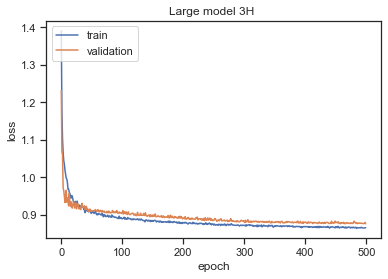

In [54]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file=f'large_model_relu_robust/model_archi.png', show_shapes=True, show_layer_names=True)
result = pd.DataFrame(size_histories['large_model_relu_robust'].history)
#result = result[~(result.index<1)]
plot_loss_acc(result, 'Large model 3H ','Large model 3H rmse', 'large_model_relu_robust/large_model_relu_robust.png', False)

In [55]:
predicted = ann.predict()

[INFO] predicting trade value...
[INFO] avg. trade value: $33,646,760.42, std trade value: $55,948,495.52
[INFO] mean: 638.05%, std: 9077.56%


In [60]:
data = main_data.groupby(['Time','Reporter', 'Category Code']).agg({output_column:'mean', 'Population':'last', 'Gdp_per_capita':'last'}).reset_index().set_index('Time')
train_data = data[data.index<"2019"]
test = data[data.index>="2019"]

test['Prediction'] = predicted

C:\Users\suzzy\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [69]:
test = test.groupby(['Category Code']).agg({output_column:'mean', 'Prediction':'mean'}).reset_index()

In [84]:
test['diff'] = test[output_column] - test['Prediction']

In [85]:
test


,Category Code,Trade Value (US$),Prediction,diff
0,6,6.010828e+07,13590126.0,4.651815e+07
1,7,9.090936e+06,14393813.0,-5.302877e+06
2,8,1.362996e+07,14373456.0,-7.435005e+05


## Other models: FB Prophet, VAR, LSTM

In [28]:
reporterencoder = LabelEncoder()
df = main_data.copy()
df["Reporter"] = reporterencoder.fit_transform(df['Reporter'])
reporter_mapping = dict(zip(reporterencoder.classes_, reporterencoder.transform(reporterencoder.classes_)))
products_mapping = {'1': 'Fruits and Vegatables', '2': 'Meat and Seafood',  '3': 'Grains and Cereals', '4':'Beverages', '5':'Dairy', '6': 'Minerals', '7': 'Base Metals', '8': 'Chemicals and Plastics', '9': 'Guns'}




## Train with fb prophet
* FB Prophet gives the best accuracy from the models tested so far
* This model is typically used for univariant time series data
* We have 

In [10]:
data = df.copy()
columns_to_remove = {'Commodity Code', 'Gdp_per_capita', 'Population'}
output_col = output_column
fb = Facebook()
predictions, final = fb.predict(data, columns_to_remove, output_col, periods=12, freq='M')


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [11]:
predictions['rsme'] = np.sqrt(predictions['mae'])
predictions

,Time,group,y_true,y_pred,mae,rsme
0,2019-01,6,7.040294e+07,6.371395e+07,6.688993e+06,2586.308683
1,2019-02,6,6.486806e+07,5.916344e+07,5.704622e+06,2388.435056
2,2019-03,6,7.066423e+07,6.367241e+07,6.991818e+06,2644.204666
3,2019-04,6,7.159249e+07,6.142269e+07,1.016979e+07,3189.011520
4,2019-05,6,7.499453e+07,6.152363e+07,1.347090e+07,3670.272442
5,2019-06,6,6.748443e+07,5.972384e+07,7.760589e+06,2785.783352
6,2019-07,6,6.990270e+07,6.169537e+07,8.207334e+06,2864.844457
7,2019-08,6,6.784476e+07,6.169157e+07,6.153190e+06,2480.562508
8,2019-09,6,6.222524e+07,5.888836e+07,3.336876e+06,1826.711701
9,2019-10,6,6.474267e+07,5.938901e+07,5.353663e+06,2313.798479


In [12]:
final.tail()

,yhat_6,yhat_7,yhat_8
ds,,,
2019-07-31,6.169157e+07,1.092034e+07,1.521511e+07
2019-08-31,5.888836e+07,1.190435e+07,1.586423e+07
2019-09-30,5.938901e+07,1.201815e+07,1.609163e+07
2019-10-31,5.860092e+07,1.158732e+07,1.554584e+07
2019-11-30,5.981840e+07,1.070520e+07,1.476445e+07


In [11]:
predictions['Product'] = ''
reporter_key_list = list(reporter_mapping.keys())
reporter_val_list = list(reporter_mapping.values())
for index, row in predictions.iterrows():
    group = row.group
    predictions.loc[index, 'Product'] = products_mapping[str(group)]
predictions = predictions.drop(columns={'group'}).rename(columns={'y_true':'Real Value', 'y_pred':'Predicted'})
predictions = predictions.set_index('Time')



In [14]:
sns.set_theme()

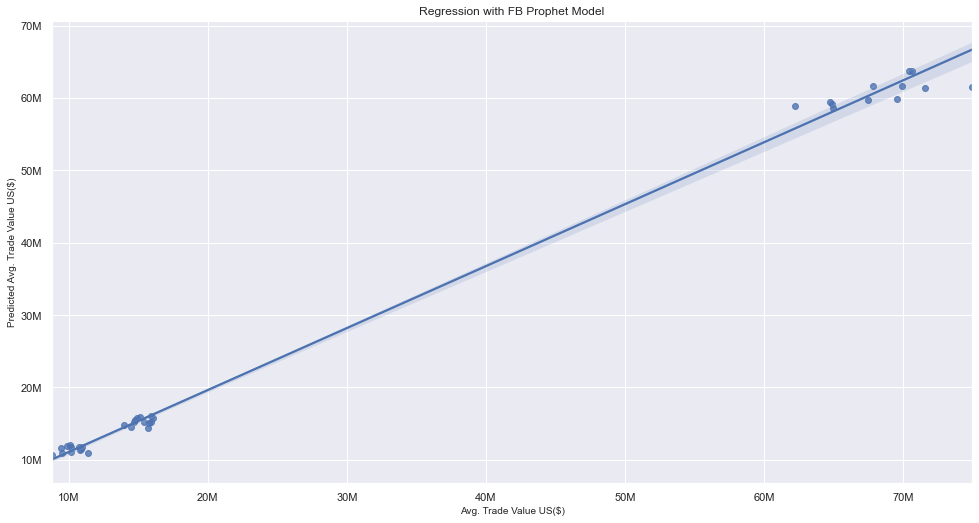

In [15]:
true_value = predictions['Real Value']
predicted_value =predictions['Predicted']
fig, ax = plt.subplots(figsize=(1,1))
fig.set_size_inches(16.5, 8.5)
g = sns.regplot(x=true_value, y=predicted_value, data=predictions, robust=True, ax=ax)
g.set_title('Regression with FB Prophet Model', size=12);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g.xaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g.set_ylabel(ylabel='Predicted Avg. Trade Value US($)', size=10);
g.set_xlabel(xlabel='Avg. Trade Value US($)', size=10);

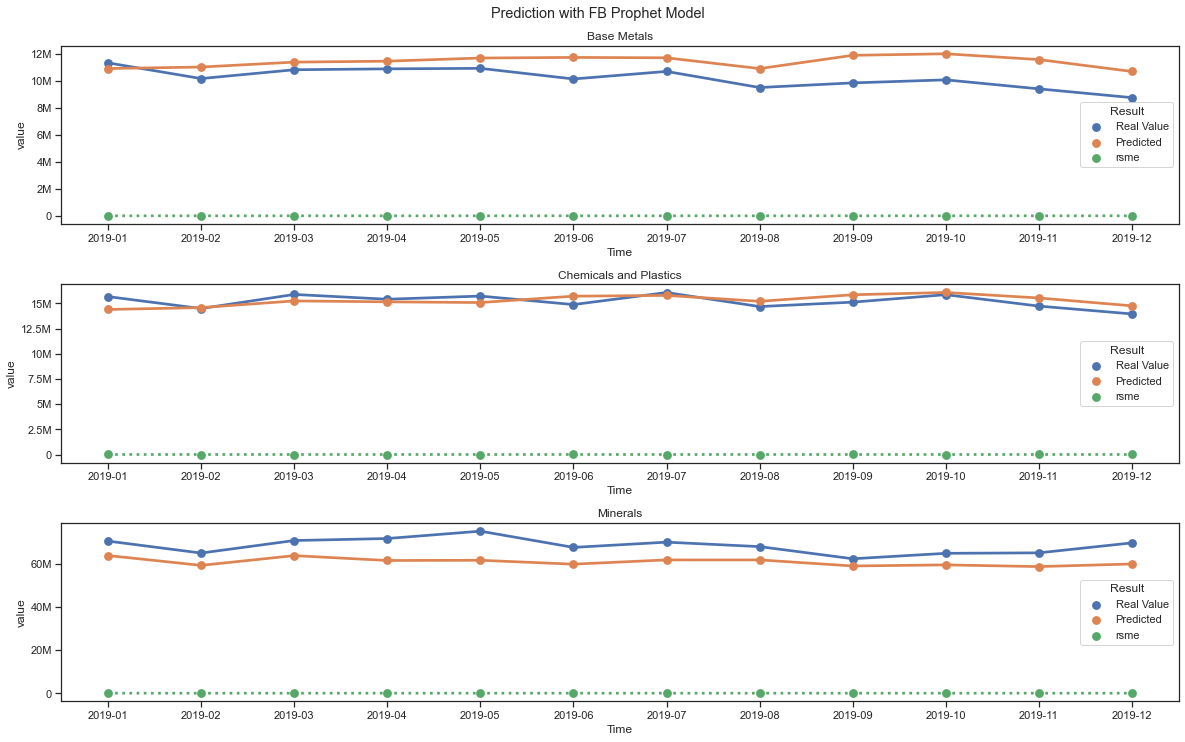

In [18]:
fig,axes= plt.subplots(nrows=3, figsize=(1,1))
fig.set_size_inches(16.5, 10.5)
grouped_predictions = predictions.groupby('Product')
sns.set(style="ticks")
for i, (g,ax) in enumerate(zip(grouped_predictions.groups, axes.flatten())):
    product_data = grouped_predictions.get_group(g)
    p = product_data.melt(value_vars=['Real Value', 'Predicted', 'rsme'], var_name="Result", ignore_index=False)
    ax = sns.pointplot(x=p.index, y=p.value, data=p, hue ="Result", ax=ax, linestyles=["-", "-", ":"]);
    ax.set_title(g)
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
fig.suptitle('Prediction with FB Prophet Model');
fig.tight_layout();

#ax2 = sns.scatterplot(x=predictions.index.month, y=true_value, data=predictions, ax=ax1)

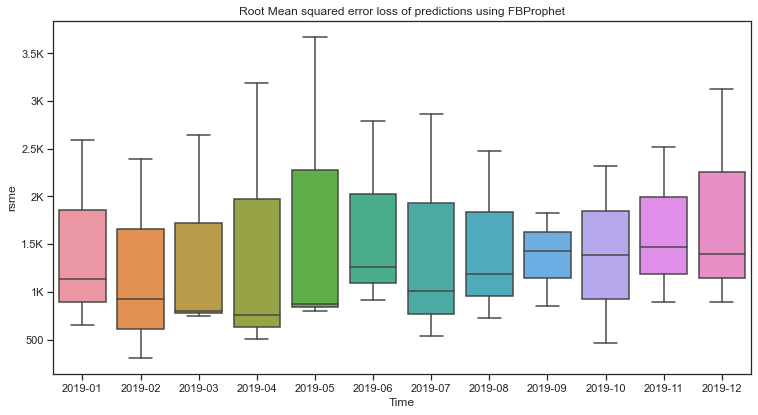

In [20]:
fig,ax= plt.subplots(figsize=(1,1))
fig.set_size_inches(12.5, 6.5)
title = "Root Mean squared error loss of predictions using FBProphet"
ax = sns.boxplot(y="rsme", x=predictions.index, data=predictions, ax=ax);
ax.set_title(title)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
#plt.suptitle(f'(Reporter, Product): {test.group.values}')


In [21]:
predictions.describe()

,Real Value,Predicted,mae,rsme
count,3.600000e+01,3.600000e+01,3.600000e+01,36.000000
mean,3.123763e+07,2.916518e+07,3.120847e+06,1509.086318
std,2.672121e+07,2.275011e+07,3.508485e+06,931.453485
min,8.764902e+06,1.070520e+07,9.259018e+04,304.286352
25%,1.088402e+07,1.174112e+07,6.423890e+05,801.491704
50%,1.527509e+07,1.523447e+07,1.340413e+06,1157.434084
75%,6.489134e+07,5.921983e+07,5.816764e+06,2411.466919
max,7.499453e+07,6.371395e+07,1.347090e+07,3670.272442


## Train with vector autoregression

## Preprocessing

In [18]:

#remove constants
data = df.loc[:, (df != df.iloc[0]).any()]
var = VAR(data, output_column, {'Commodity Code'})


33756 3528


In [19]:
var.train_var = var.train_var.loc[:, (var.train_var != var.train_var.iloc[0]).any()]
var.test_var = var.test_var.loc[:, (var.test_var != var.test_var.iloc[0]).any()]

In [14]:
var.adf_test(var.train_var[output_column])

Test Statistic         -6.451940e+00
p-value                 1.515886e-08
# Lags                  3.700000e+01
# Observations          8.401000e+03
Critical Value (1%)    -3.431129e+00
Critical Value (5%)    -2.861884e+00
Critical Value (10%)   -2.566953e+00
dtype: float64
 Series is Stationary


In [15]:
var.show_lag_orders([6])


 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0       40.82       40.82   5.349e+17       40.82
1       39.73       39.74   1.792e+17       39.73
2       39.48       39.50   1.403e+17       39.49
3       39.45       39.48   1.365e+17       39.47
4       39.34       39.38   1.222e+17       39.36
5       39.30       39.35   1.170e+17       39.32
6      39.28*      39.33*  1.145e+17*      39.30*
-------------------------------------------------
Lag Order = 6
AIC :  39.27943361552548
BIC :  39.332103995757066
FPE :  1.1450944787671517e+17
HQIC:  39.298392602019675 



In the above output, the AIC drops to lowest at lag 26. So we pick lag 1

In [20]:
max_lag = 15
opt_lag = 1

A common way of checking for serial correlation of errors can be measured using the Durbin Watson’s Statistic. The value of this statistic can vary between 0 and 4. The closer it is to the value 2, then there is no significant serial correlation. The closer to 0, there is a positive serial correlation, and the closer it is to 4 implies negative serial correlation.

In [21]:

grouped = var.train_var.groupby(['Category Code'])
train_results = var.train(max_lag, grouped)


Trade Value (US$) : 1.98
Population : 2.0
Trade Value (US$) : 1.98
Population : 2.02
Trade Value (US$) : 1.98
Population : 2.01


In [33]:
for key, value in train_results.items():
    fevd = value.fevd(5)
    print(f"Fevd estimation {key}\n{fevd.summary()}")

FEVD for Trade Value (US$)
     Trade Value (US$)  Population
0             1.000000    0.000000
1             0.999969    0.000031
2             0.999630    0.000370
3             0.996983    0.003017
4             0.964991    0.035009

FEVD for Population
     Trade Value (US$)  Population
0             0.215507    0.784493
1             0.238868    0.761132
2             0.252652    0.747348
3             0.255592    0.744408
4             0.255182    0.744818


Fevd estimation 6
None
FEVD for Trade Value (US$)
     Trade Value (US$)  Population
0             1.000000    0.000000
1             0.993846    0.006154
2             0.988604    0.011396
3             0.987122    0.012878
4             0.986941    0.013059

FEVD for Population
     Trade Value (US$)  Population
0             0.158151    0.841849
1             0.159043    0.840957
2             0.157615    0.842385
3             0.157071    0.842929
4             0.164699    0.835301


Fevd estimation 7
None
FEVD for Trade

In [34]:
# forecasting
test_grouped = var.test_var.groupby(['Category Code'])
forecasts = var.forecast(12, grouped, test_grouped, train_results, products_mapping)


In [35]:
test_values = var.test_var.copy()
test_values = test_values.reset_index()
test_values['Product'] = ''
for index, row in test_values.iterrows():
    test_values.loc[index, 'Product'] = products_mapping[str(row['Category Code'])]
test_values = test_values.drop(columns={'Reporter', 'Category Code'})

In [36]:
from sklearn.metrics import mean_squared_error
predictions = forecasts.copy().reset_index()
predictions['Real Value'] = test_values.reset_index()[output_column]
predictions = predictions.rename(columns={'index':'Time', 'Trade Value (US$)': 'Predicted'})

predictions['mae']=predictions.apply(lambda row: mean_squared_error([row['Real Value']], [row['Predicted']]), axis=1)
predictions = predictions.drop(columns={'Population'})
predictions = predictions.set_index('Time')

In [37]:
predictions['rsme'] = np.sqrt(predictions['mae'])
predictions.head()

,Predicted,Product,Real Value,mae,rsme
Time,,,,,
2019-01,8.019082e+07,Minerals,8.679441e+06,5.113878e+15,7.151138e+07
2019-02,3.507649e+07,Minerals,1.755479e+06,1.110290e+15,3.332101e+07
2019-03,6.460328e+07,Minerals,3.192190e+06,3.771322e+15,6.141109e+07
2019-04,4.749384e+07,Minerals,4.134887e+07,3.776062e+13,6.144967e+06
2019-05,8.544117e+07,Minerals,4.992466e+06,6.471994e+15,8.044871e+07


In [38]:
sns.set_theme()

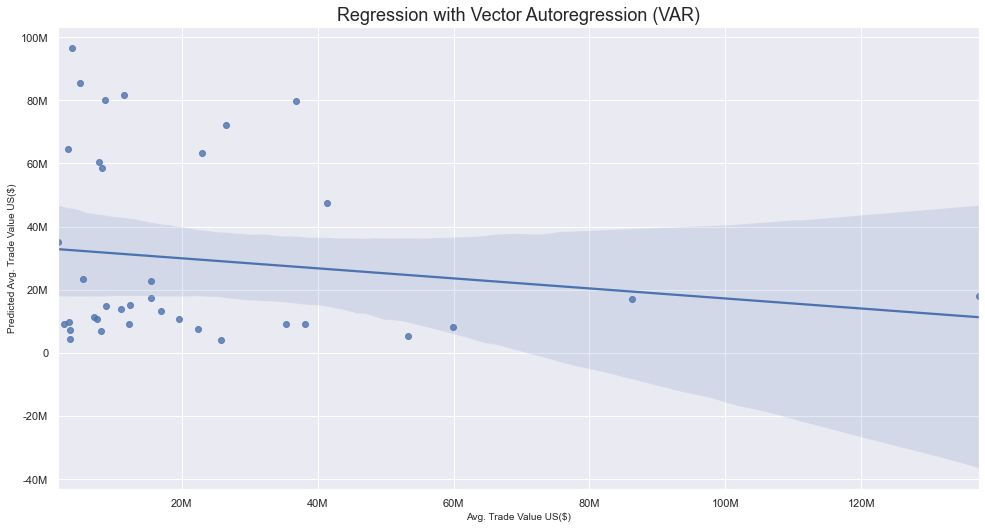

In [39]:
true_value = predictions['Real Value']
predicted_value =predictions['Predicted']
fig, ax = plt.subplots(figsize=(1,1))
fig.set_size_inches(16.5, 8.5)
g = sns.regplot(x=true_value, y=predicted_value, data=predictions, robust=True, ax=ax)
g.set_title('Regression with Vector Autoregression (VAR)', size=18);
g.yaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g.xaxis.set_major_formatter(ticker.FuncFormatter(utils.human_format));
g.set_ylabel(ylabel='Predicted Avg. Trade Value US($)', size=10);
g.set_xlabel(xlabel='Avg. Trade Value US($)', size=10);

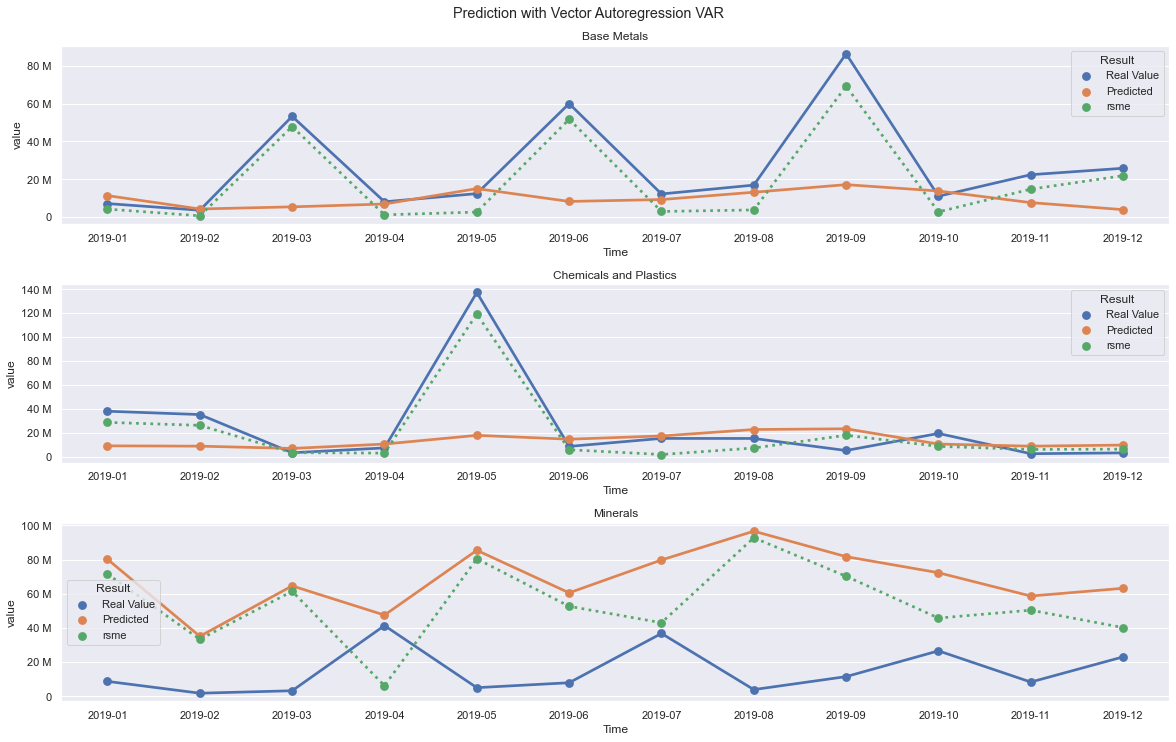

In [40]:
fig,axes= plt.subplots(nrows=3, figsize=(1,1))
fig.set_size_inches(16.5, 10.5)
grouped_predictions = predictions.groupby('Product')
sns.set_theme()
for i, (g,ax) in enumerate(zip(grouped_predictions.groups, axes.flatten())):
    product_data = grouped_predictions.get_group(g)
    p = product_data.melt(value_vars=['Real Value', 'Predicted', 'rsme'], var_name="Result", ignore_index=False)
    ax = sns.pointplot(x=p.index, y=p.value, data=p, hue ="Result", ax=ax, linestyles=["-", "-", ":"]);
    ax.set_title(g)
    ax.yaxis.set_major_formatter(ticker.EngFormatter());
fig.suptitle('Prediction with Vector Autoregression VAR');
fig.tight_layout();

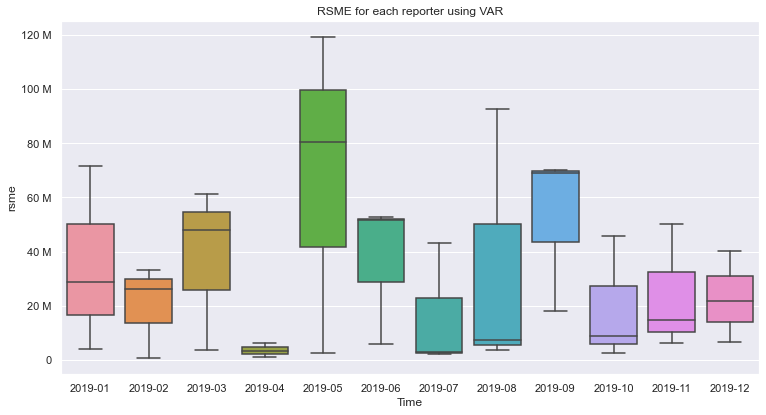

In [41]:
#Box plot
title = 'RSME for each reporter using VAR'
fig,ax= plt.subplots(figsize=(1,1))
fig.set_size_inches(12.5, 6.5)
ax = sns.boxplot(y="rsme", x=predictions.index, data=predictions, ax=ax);
ax.yaxis.set_major_formatter(ticker.EngFormatter())
ax.set_title(title);

In [42]:
predictions.describe()

,Predicted,Real Value,mae,rsme
count,3.600000e+01,3.600000e+01,3.600000e+01,3.600000e+01
mean,3.067786e+07,2.193314e+07,1.882335e+15,3.077572e+07
std,2.932953e+07,2.718152e+07,3.013175e+15,3.101467e+07
min,3.923760e+06,1.755479e+06,4.403029e+11,6.635532e+05
25%,9.198640e+06,6.697244e+06,1.683749e+13,4.099020e+06
50%,1.492969e+07,1.184227e+07,4.036031e+14,2.000221e+07
75%,5.912224e+07,2.598934e+07,2.571169e+15,5.070340e+07
max,9.663483e+07,1.372513e+08,1.421368e+16,1.192211e+08


## LSTM

In [14]:
data = main_data.groupby(['Time','Reporter', 'Category Code','Commodity Code']).agg({output_column:'mean', 'Population':'last', 'Gdp_per_capita':'last'}).reset_index().set_index('Time')
dum_df = pd.get_dummies(data, columns=["Reporter", "Commodity Code", "Category Code"])
data = dum_df.copy()
train = data[data.index<"2019"]
test = data[data.index >= "2019"]
input_columns = ['Gdp_per_capita', 'Population']
lstm = LSTM(data, train, test, input_columns, output_column)
lstm.scale()

* Train with LSTM
* reshape to [samples, time_steps, n_features]

In [16]:

#results = pd.DataFrame()
#batches = [12, 24, 32, 64, 80]
#time_steps = [12, 50, 60, 70, 80]
#layers = [1, 1, 2, 2, 2]
#neurons = [128, 128, 256, 312, 500]
#train using past 36 months data to predict next twelve months
hparams = {"time_steps":36, "neurons":128, "dropout":0.2, "layers":1, "epochs":30, "batch":12, "lr":0.001}
model, hist_df = lstm.train(hparams, 'lstmmodels')
    


Epoch 1/30
4390/4390 [==============================] - 1237s 278ms/step - loss: 145.9403 - val_loss: 1.6568
Epoch 2/30
4390/4390 [==============================] - 415s 94ms/step - loss: 2.5052 - val_loss: 1.3415
Epoch 3/30
4390/4390 [==============================] - 166s 38ms/step - loss: 1.8636 - val_loss: 0.8190
Epoch 4/30
4390/4390 [==============================] - 161s 37ms/step - loss: 1.4681 - val_loss: 0.6917
Epoch 5/30
4390/4390 [==============================] - 165s 38ms/step - loss: 1.2179 - val_loss: 0.6733
Epoch 6/30
4390/4390 [==============================] - 162s 37ms/step - loss: 1.1768 - val_loss: 0.6106
Epoch 7/30
4390/4390 [==============================] - 159s 36ms/step - loss: 1.0952 - val_loss: 0.6435
Epoch 8/30
4390/4390 [==============================] - 159s 36ms/step - loss: 0.9824 - val_loss: 0.7515
Epoch 9/30
4390/4390 [==============================] - 144s 33ms/step - loss: 0.9287 - val_loss: 0.6520
Epoch 10/30
4390/4390 [============================

FileNotFoundError: [Errno 2] No such file or directory: 'lstmmodels/history_128.csv'

In [ ]:
df_results = pd.DataFrame()
filenames = ['history_0.csv', 'history_2.csv',
	'history_3.csv','history_4','history_5.csv']
for name in filenames:
	df_results[name[0:-9]] = read_csv(name, header=0)
# describe all results
print(df_results.describe())
# box and whisker plot
df_results.boxplot()
plt.show()

* Using one layer bi-directional lstm with a drop out layer

# Predict only after satification with train result
* Now we predict for 2019

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_train_inv = tradeval_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = tradeval_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = tradeval_transformer.inverse_transform(y_pred)

In [ ]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Trade value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [ ]:
plt.plot(y_test_inv.flatten(), marker='.', label="true")
plt.plot(y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Trade value')
plt.xlabel('Time Step')
plt.legend()
plt.show();